In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

### Notes on the choice of limma-voom over DESeq2:
 - the author of DESeq2 acknowledged that the differences are not significant and provides very through comparative analysis: [blogpost](https://mikelove.wordpress.com/2016/09/28/deseq2-or-edger/), [all plots](https://github.com/mikelove/deseq2_or_edger/blob/master/plots.md), [code](https://github.com/mikelove/deseq2_or_edger)
 - in my empirical experience many scientists oppose the use of limma for RNASeq data, which seems to based be an artifact of the past; granted original limma is worse than many methods for RNASeq data, though for several years now (4? 5?) limma with trend correction/voom has entered the field achieving comparable or better results than most of the methods.
 - this may have been exacerbated by the benchmarking differences in the DESeq2 publication, which as author states in the linked blog post:  
  >  "My original 2014 analysis did not use CPM filtering for edgeR or limma-voom, which should be used for an accurate assessment [...] The figure looks roughly similar to (1 – precision) in Figure 9 of the DESeq2 paper (thresholding at 10% nominal FDR), except the CPM filtering definitely improves the performance of limma-voom."
 - finally, I want to use limma-voom as to have a consistent methodology between proteomic and transcriptomic data and this is the main argument; while I am sure that DESeq2 is better than voom for certain applications, the nice gain of reducing the burden of differences between methods justifies the choice in my opinion.
 
Some support for my sentiment - have a look at https://www.biostars.org/p/284775/#382693 (and my comment); the reply was written 1.5 years ago but uses publication from 2013 - 6 years ago (before the release of DESeq2 and limma-trend/voom!). Conclusion: when releasing an improved method, better change the name...

### Comparative studies for limma/DESeq2:
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6509820/
 - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0103207 (2014):
     - does not take limma-voom into account, really outdated
 - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0190152 (2018)
     - DESeq2 the best, though only slightly better than limma+voom (F1 0.88 vs 0.85, TPR 0.84 vs 0.81)
     - external validity limited by small number of experimental designs considered (Mike Love’s blog post highlighted that the major difference between the methods is in how they perform against low/large numbers of samples in groups and outliers)
     - authors summary:
       > The NOIseq, DESeq2 and limma+voom methods performed well, with high TPR and ACC rates. The limma+voom tool had already been pointed out in previous works as one of the better results in the DEG ranking and for analyses with more than two samples [22]. NOIseq and DESeq2 tools showed consistent results, indicating these methods are suitable for experiments with a large number of samples and an annotated genome.
     - the authors claim that combining results from five methods is even better than each individual one  (which seems plausible, did not read at critical level yet though)

Inputs and outputs:

In [3]:
clinical_deseq2_path = 'data/clean/rna/clinical_data_ordered_to_match_rna_deseq2.csv'
clinical_counts_path = 'data/clean/rna/clinical_data_ordered_to_match_rna_counts.csv'

# normalized counts
deseq2_path = 'data/clean/rna/all_samples.csv'
# raw counts
counts_path = 'data/clean/rna/all_samples_counts.csv'

ensembl_to_entrez_path = 'data/ensembl_to_entrez.csv'

# for comparison
definite_tbm_cm_deg_path = 'data/preliminary_analyses/deg/definite_tbm-cm.csv'
definite_tbm_vm_deg_path = 'data/preliminary_analyses/deg/definite_tbm-vm.csv'

# outputs
results_path = 'data/preliminary_analyses/differential_rna_expression/'

rna_tmm_normalized_counts_path = 'data/preliminary_analyses/differential_rna_expression/normalized_counts/tmm_for_subsets.csv'
rna_rle_normalized_counts_path = 'data/preliminary_analyses/differential_rna_expression/normalized_counts/rle_for_subsets.csv'

In [4]:
clinical_deseq2 = read_csv(clinical_deseq2_path, index_col=0)
clinical_counts = read_csv(clinical_counts_path, index_col=0)

raw_deseq2_matrix = read_csv(deseq2_path, index_col=[0, 1])
raw_counts_matrix = read_csv(counts_path, index_col=0)

reference_definite_tbm_cm_deg = read_csv(definite_tbm_cm_deg_path, index_col=0)
reference_definite_tbm_vm_deg = read_csv(definite_tbm_vm_deg_path, index_col=0)

In [5]:
reference_definite_tbm_cm_deg.head()

ensembl_gene_name  \
ensembl_id                          
ENSG00000100226            GTPBP1   
ENSG00000165997             ARL5B   
ENSG00000164691             TAGAP   
ENSG00000108771             DHX58   
ENSG00000128016             ZFP36   

                                                     description     baseMean  \
ensembl_id                                                                      
ENSG00000100226                           GTP binding protein 1    580.453924   
ENSG00000165997          ADP ribosylation factor like GTPase 5B    222.402492   
ENSG00000164691  T-cell activation RhoGTPase activating protein   1023.319959   
ENSG00000108771                            DExH-box helicase 58    125.298558   
ENSG00000128016                       ZFP36 ring finger protein   2070.881325   

                 log2FoldChange     lfcSE      stat        pvalue      padj  
ensembl_id                                                                   
ENSG00000100226        1.192190  0.219708  5.426243  5.755269e-08  0.000517  
ENSG00000165997        1.963330  0.393233  4.992789  5.951353e-07  0.001903  
ENSG00000164691        1.964425  0.394441  4.980279  6.349261e-07  0.001903  
ENSG00000108771        1.785542  0.367150  4.863249  1.154747e-06  0.002481  
ENSG00000128016        1.683438  0.348691  4.827880  1.379940e-06  0.002481

In [6]:
raw_counts_matrix.head()

001.TMD  006.CM  012.BM  016.CM  017.TMD  ...  158.TMD  \
ENSG00000000003      1.0     3.0    2.00   16.00    25.00  ...      0.0   
ENSG00000000005      0.0     0.0    0.00    1.00     0.00  ...      0.0   
ENSG00000000419      0.0    12.0   53.00    0.00    73.00  ...      0.0   
ENSG00000000457     11.0    56.0  123.84   38.72   124.95  ...      0.0   
ENSG00000000460      4.0     0.0   73.16   21.28    15.05  ...      0.0   

                 167.TMR  175.TMD  233.CM  261.CM  
ENSG00000000003      0.0      0.0     0.0   25.00  
ENSG00000000005      0.0      0.0     0.0    5.00  
ENSG00000000419      0.0      0.0     0.0   48.00  
ENSG00000000457      0.0      0.0     0.0  151.94  
ENSG00000000460      0.0      0.0     0.0   37.06  

[5 rows x 56 columns]

In [7]:
# note: this is already limitted to the patients having the RNASeq measurments
by_condition = clinical_deseq2.Meningitis
by_condition_and_tb_subset = clinical_deseq2.Meningitis_with_tuberculosis_status
by_condition_and_tb_subset.head()

001.TMD    Definite tuberculosis
006.CM              Cryptococcal
012.BM                 Bacterial
016.CM              Cryptococcal
017.TMD    Definite tuberculosis
Name: Meningitis_with_tuberculosis_status, dtype: object

In [8]:
%R -i by_condition_and_tb_subset -i by_condition

In [9]:
raw_deseq2_matrix = raw_deseq2_matrix.reset_index()
raw_deseq2_matrix = raw_deseq2_matrix.drop(columns=['ensembl_gene_id']).set_index('ensembl_id')

## Using DESeq2 normalized counts

### What are the DESeq2 normalized counts?

In [10]:
%%R
import::here(space_to_dot, dot_to_space, remove_leading_X, .from='helpers/utilities.R')

In [11]:
%%R -i raw_counts_matrix -i raw_deseq2_matrix
colnames(raw_counts_matrix) = remove_leading_X(colnames(raw_counts_matrix))
colnames(raw_deseq2_matrix) = remove_leading_X(colnames(raw_deseq2_matrix))

In [12]:
raw_deseq2_matrix.head(n=2)

001.TMD    006.CM    012.BM     016.CM    017.TMD  ...  \
ensembl_id                                                            ...   
ENSG00000000003  11.596119  7.806308  1.391555  39.347366  24.765008  ...   
ENSG00000000005   0.000000  0.000000  0.000000   2.459210   0.000000  ...   

                   174.CM    011.TMR    043.TMS  078.CM     261.CM  
ensembl_id                                                          
ENSG00000000003  4.431071  51.810470  35.628629     0.0  20.705553  
ENSG00000000005  0.000000  11.102244   0.000000     0.0   4.141111  

[2 rows x 49 columns]

In [13]:
raw_counts_matrix.head(n=2)

001.TMD  006.CM  012.BM  016.CM  017.TMD  ...  158.TMD  \
ENSG00000000003      1.0     3.0     2.0    16.0     25.0  ...      0.0   
ENSG00000000005      0.0     0.0     0.0     1.0      0.0  ...      0.0   

                 167.TMR  175.TMD  233.CM  261.CM  
ENSG00000000003      0.0      0.0     0.0    25.0  
ENSG00000000005      0.0      0.0     0.0     5.0  

[2 rows x 56 columns]

As expected, there is a considerable difference between the "raw" RSEM counts and the DESeq2 normalized counts: 

In [14]:
%%R
reference_samples = colnames(raw_deseq2_matrix)
reference_genes = rownames(raw_deseq2_matrix)

raw_counts_trimmed = raw_counts_matrix[reference_genes, reference_samples]

relative_mean_diff = function(a, b) {
    ma = mean(rowMeans(a))
    mb = mean(rowMeans(b))
    mean(rowMeans(
        abs(a / ma - b / mb) * 100,
    ))
}

relative_mean_diff(raw_deseq2_matrix, raw_counts_trimmed)

[1] 61.80482


#### Can I recreate the DESeq2 normalization?

In [15]:
%%R
conditions_for_deseq = by_condition_and_tb_subset[reference_samples, drop=F]

dds <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_trimmed),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)
# DESeq call can be skipped, as it performs dispersion estimation
# and GLM fitting which are not required for size estimation,
# see https://support.bioconductor.org/p/109586/
# dds <- DESeq2::DESeq(dds)
dds <- DESeq2::estimateSizeFactors(dds)

converting counts to integer mode
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]


In [16]:
%%R -o normalized_counts
normalized_counts = as.data.frame(DESeq2::counts(dds, normalized=TRUE))

In [17]:
%%R
relative_mean_diff(raw_deseq2_matrix, normalized_counts)

[1] 9.977589e-09


Yes. This is exactly what I was given.

I understand that the very small difference is due to rounding precision and the file being exported to Excel and then imported in Python; on the high level the values are close enough though:

In [18]:
np.allclose(normalized_counts.values, raw_deseq2_matrix.values)

True

In [19]:
normalized_counts.head(2)

001.TMD    006.CM    012.BM     016.CM    017.TMD  ...  \
ENSG00000000003  11.596119  7.806308  1.391555  39.347366  24.765008  ...   
ENSG00000000005   0.000000  0.000000  0.000000   2.459210   0.000000  ...   

                   174.CM    011.TMR    043.TMS  078.CM     261.CM  
ENSG00000000003  4.431071  51.810470  35.628629     0.0  20.705553  
ENSG00000000005  0.000000  11.102244   0.000000     0.0   4.141111  

[2 rows x 49 columns]

In [20]:
raw_deseq2_matrix.head(2)

001.TMD    006.CM    012.BM     016.CM    017.TMD  ...  \
ensembl_id                                                            ...   
ENSG00000000003  11.596119  7.806308  1.391555  39.347366  24.765008  ...   
ENSG00000000005   0.000000  0.000000  0.000000   2.459210   0.000000  ...   

                   174.CM    011.TMR    043.TMS  078.CM     261.CM  
ensembl_id                                                          
ENSG00000000003  4.431071  51.810470  35.628629     0.0  20.705553  
ENSG00000000005  0.000000  11.102244   0.000000     0.0   4.141111  

[2 rows x 49 columns]

The normalization shown above [corresponds to](https://support.bioconductor.org/p/66067/):

In [21]:
%%R -o counts_normalized_manually
counts_normalized_manually = as.data.frame(DESeq2::counts(dds) / DESeq2::sizeFactors(dds))

Notably, these normalised counts are not really used so much in the actual DESeq2 method, just for the mean-variance trend estimation:

> The point of the software and other count-based methods is to model the raw counts, so that estimation steps take into account the variance profile of counts. If you look over the methods, you'll see that almost all steps use K_ij which is the raw count for gene i and sample j. The normalized counts K_ij/s_j are only used to give each gene a single mean value for the dispersion trend regression (equation 5). [https://support.bioconductor.org/p/66067/#66081]

And the size factors are computed using:
> "median ratio method" described by Equation 5 in Anders and Huber (2010) [(DESeq2 documentation, estimateSizeFactors)](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/estimateSizeFactors)

The size factors are meant to make counts for different samples (patients) comparable; DESeq uses median of ratios of counts to geometric mean of counts in each sample [(Anders and Huber, 2010)](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-10-r106):

$$\hat s_j = \text{median}_{i=1}^n \frac{k_{i,j}}{\left(\prod^m_{v=1} k_{i,v}\right)^{1/m}}$$

where:
 - $i$ indexes genes ($n$ in total)
 - $j$ and $v$ indexes samples, $m$ in total
 - $k_{i,j}$ represents raw count for gene $i$ and sample $j$

### Filtering and normalization

Using protocol from limma's User Guide:

In [22]:
%%R
import::here(
    design_from_conditions, calculate_means, limma_fit, contrasts_fit,
    .from='helpers/differential_expression.R'
)

In [23]:
%%R
dge_all <- edgeR::DGEList(counts=raw_deseq2_matrix, group=by_condition)
design = design_from_conditions(by_condition, intercept=F)
length(rownames(dge_all))

[1] 38664


Keeping most of the genes. Note this is not fully valid given that this function was written for raw counts data, not normalized data.

In [24]:
%%R
keep <- edgeR::filterByExpr(dge_all, design)
sum(keep) / length(rownames(dge_all)) * 100

[1] 97.72139


In [25]:
%%R
dge <- dge_all[keep,,keep.lib.sizes=FALSE]

Normal procedure for limma/edgeR adds TMM normalization factors now, but since we already have normalized counts I will skip this step.

**Note 1 (TMM)**: TMM stands for *trimmed mean of M-values* which was introduced by [(Robinson and Oshlack, 2010)](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-3-r25); it is calculated by `edgeR::calcNormFactors` in limma's pipeline. The goal is the same as for the median normalization in DESeq2.

**Note 2 (comparable)**: 
The TMM and DESeq's median based normalization (sometimes called "Relative Log Expression" RLE) were shown to give very comparable results in simulation studies [(Maza, 2013)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3918003/) [see table 2] and [(Dillies et al, 2012)](https://academic.oup.com/bib/article/14/6/671/189645) [see table 3] and may produce equivalent results under some additional assumptions [(Maza, 2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5025571/).

**Note 3 (assumptions)**: Both assume that they can capture the scaling factor from the non-differentially expressed genes (see [here](https://support.bioconductor.org/p/63630/) for some more intuition). **This could be a problem in our study design...** But do we have anything better?

### Transformation

The TMM normalization factors would be used by `edgeR::cpm` now; however, as in this case the counts are already normalized I will use simpler, equivalent log2-transformation (corresponds to `edgeR::cpm(dge, log=T, prior.count=0.25)`)

In [26]:
%%R
log_cpm = log2(dge$counts + 0.25)

**Note**: previously I was adding `eps = .Machine$double.eps` as a damping factor and the very low numbers (while not technically zero) were the cause of the "stripy" patterns in average log-expression/variance:
because these led to high negative log-expression values, the quantification of read counts started to emerge on the x axis: the damping factor not only prevents the infinite values of the log function, but also "attracts" the values for counts closer together.

In [27]:
%R head(as.data.frame(log_cpm), n=2)

001.TMD    006.CM    012.BM    016.CM   017.TMD  ...  \
ENSG00000000003  3.566343  3.010119  0.715063  5.307333  4.644722  ...   
ENSG00000000005 -2.000000 -2.000000 -2.000000  1.437872 -2.000000  ...   

                   174.CM   011.TMR   043.TMS  078.CM    261.CM  
ENSG00000000003  2.226839  5.702116  5.165053    -2.0  4.389261  
ENSG00000000005 -2.000000  3.504906 -2.000000    -2.0  2.134586  

[2 rows x 49 columns]

### Fitting

#### Assessing the the mean-variance relation

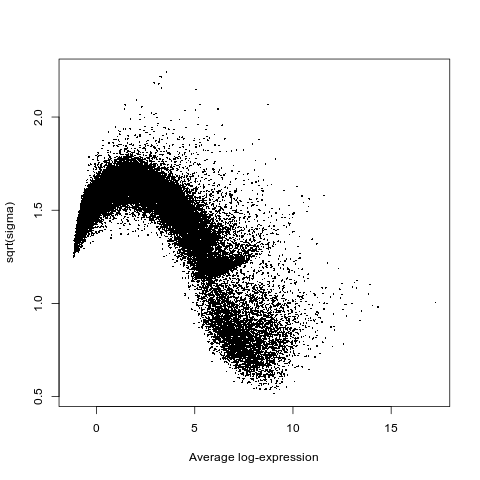

In [28]:
%%R
fit <- limma_fit(data=log_cpm, conditions=by_condition, a='Tuberculosis', b='Cryptococcal')
limma::plotSA(fit)

It looks ok, though the cut-off might have been more stringent. There is one suspected outlier (very highly expressed gene), but this one seems to be present across samples (see the raw-counts analysis).

In [29]:
%%R
limma_dge = function(a, b, data, conditions, ...) {
    raw_fit <- limma_fit(data=data, conditions_vector=conditions, a=a, b=b)
    fit <- limma::eBayes(raw_fit, trend=T, robust=T)
    limma::topTable(fit, ...)
}

In [30]:
%R limma_dge('Tuberculosis', 'Cryptococcal', log_cpm, by_condition)

logFC   AveExpr         t   P.Value  adj.P.Val         B
ENSG00000241313 -3.750636  1.848536 -4.964503  0.000005   0.127865  3.638567
ENSG00000280809 -3.551704  1.393227 -4.865163  0.000007   0.127865  3.324216
ENSG00000179412 -3.687491  0.189983 -4.741177  0.000011   0.135827  2.935682
ENSG00000266486 -3.409226  0.586013 -4.442458  0.000032   0.148125  2.018622
ENSG00000271397 -3.137736  0.096760 -4.426891  0.000034   0.148125  1.971626
ENSG00000264714 -3.703843  2.563455 -4.395866  0.000038   0.148125  1.878210
ENSG00000187848 -3.289822  0.776672 -4.358709  0.000044   0.148125  1.766772
ENSG00000272975 -3.592755  1.430871 -4.352362  0.000045   0.148125  1.747787
ENSG00000224791 -3.359333  0.902272 -4.330312  0.000049   0.148125  1.681937
ENSG00000158163 -3.175936  3.185874 -4.324983  0.000049   0.148125  1.666046

The adjusted p-values seem relatively high.

#### Comparing top genes called by limma and by DESeq2

In [31]:
%%R -o definite_tb_cm
definite_tb_cm = limma_dge('Definite tuberculosis', 'Cryptococcal', log_cpm, by_condition_and_tb_subset, n=15)

In [32]:
definite_tb_cm.head()

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000104415 -4.554774  3.116708 -5.490432  6.153383e-07   0.023249   
ENSG00000231768 -4.365053  2.347671 -4.720467  1.182595e-05   0.219238   
ENSG00000100226  1.024016  8.934570  4.615991  1.740770e-05   0.219238   
ENSG00000117298  1.416507  8.918096  4.551910  2.414474e-05   0.228065   
ENSG00000213568 -3.904801  0.613604 -4.402567  3.787167e-05   0.261826   

                        B  
ENSG00000104415  4.800344  
ENSG00000231768  2.512380  
ENSG00000100226  2.212059  
ENSG00000117298  1.955966  
ENSG00000213568  1.607919

The p-values are lower (possibly we get more consistent support for these DEGs) while the adjusted p-values get higher (possibly due to fewer samples giving the support).

In [33]:
reference_definite_tbm_cm_deg.head()

ensembl_gene_name  \
ensembl_id                          
ENSG00000100226            GTPBP1   
ENSG00000165997             ARL5B   
ENSG00000164691             TAGAP   
ENSG00000108771             DHX58   
ENSG00000128016             ZFP36   

                                                     description     baseMean  \
ensembl_id                                                                      
ENSG00000100226                           GTP binding protein 1    580.453924   
ENSG00000165997          ADP ribosylation factor like GTPase 5B    222.402492   
ENSG00000164691  T-cell activation RhoGTPase activating protein   1023.319959   
ENSG00000108771                            DExH-box helicase 58    125.298558   
ENSG00000128016                       ZFP36 ring finger protein   2070.881325   

                 log2FoldChange     lfcSE      stat        pvalue      padj  
ensembl_id                                                                   
ENSG00000100226        1.192190  0.219708  5.426243  5.755269e-08  0.000517  
ENSG00000165997        1.963330  0.393233  4.992789  5.951353e-07  0.001903  
ENSG00000164691        1.964425  0.394441  4.980279  6.349261e-07  0.001903  
ENSG00000108771        1.785542  0.367150  4.863249  1.154747e-06  0.002481  
ENSG00000128016        1.683438  0.348691  4.827880  1.379940e-06  0.002481

In [34]:
top_reference = reference_definite_tbm_cm_deg.head(15).index
top_limma = definite_tb_cm.index

In [35]:
intersection = set(top_reference) & set(top_limma)
intersection

{'ENSG00000100226',
 'ENSG00000108771',
 'ENSG00000117298',
 'ENSG00000155363',
 'ENSG00000185507'}

5 out of 15 - not bad; however the only "significant" gene: ENSG00000104415 was not scored as high by DESeq2; was it deemed significant at all?

In [36]:
reference_definite_tbm_cm_deg.loc[['ENSG00000104415']]

ensembl_gene_name  \
ensembl_id                          
ENSG00000104415             WISP1   

                                                 description  baseMean  \
ensembl_id                                                               
ENSG00000104415  WNT1 inducible signaling pathway protein 1   22.30457   

                 log2FoldChange     lfcSE      stat    pvalue  padj  
ensembl_id                                                           
ENSG00000104415       -2.882794  0.623437 -4.624037  0.000004   NaN

Well... what does NaN mean for adjusted p-value?

> If a row is filtered by automatic independent filtering, for having a low mean normalized count, then only the adjusted p value will be set to  NA. Description and customization of independent filtering is described below 
> [(DESeq2 vignette)](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#pvaluesNA)

So the independent filtering is an interesting way (or trick) of decreasing the FDR/adjusted p-value by disregarding some hypotheses upfront. The criterion used by DESeq2 is having a small number of normalized counts (regardless of the condition). For more details see the plot and explanation in the [DESeq2 vignette](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilttheory).

## Using RSEM counts

These counts are RSEM gene-level expected counts. Can we use limma-voom on RSEM rather than on raw counts?
Yes.

> If you are working with RSEM gene-level expected counts, then you can just pass them to limma as if they were counts. That's what we do. \[limma's author answering [this Bioconductor question](https://support.bioconductor.org/p/84749/#84807)\]

Side note: another, related answer from prof Gordon: https://support.bioconductor.org/p/91054/#91098 highlights use of `normalizeQuantiles` when applying limma to log(counts), but this is not needed for this project generally (as in any case we can proceed with TMM/RLE normalization).

### Outliers

#### Removing patients without clinical data?

The raw counts have for a few patients excluded from initial version of clinical dataset as those were marked as outliers:

In [37]:
patients_initially_excluded = ['233.CM', '167.TMR', '158.TMD']

In [38]:
samples = read_csv('data/clean/samples_list.csv')

assert all(p not in set(samples.sample_id) for p in patients_initially_excluded)

However, data for those patients were added for consistency:

In [39]:
assert all(p in set(clinical_counts.index) for p in patients_initially_excluded)

Let's investigate library sizes of these samples:

In [40]:
patients_absent_in_clinical_data = patients_initially_excluded
patients_absent_in_processsed_counts = set(raw_counts_matrix.columns) - set(raw_deseq2_matrix.columns)

In [41]:
sizes = raw_counts_matrix.sum().to_frame('library_size').reset_index()
sizes['label'] = np.where(
    sizes['index'].isin(patients_absent_in_processsed_counts),
    sizes['index'], ''
)
absent_samples = (
    set(patients_absent_in_clinical_data)
    |
    set(patients_absent_in_processsed_counts)
)
sizes['status'] = sizes.apply(lambda sample: (
    'Present'
    if sample['index'] not in absent_samples else
    (
        'Excluded in inital clinical datasheet'
        if sample['index'] in patients_absent_in_clinical_data else
        'Absent in processed counts'
    )
), axis=1)

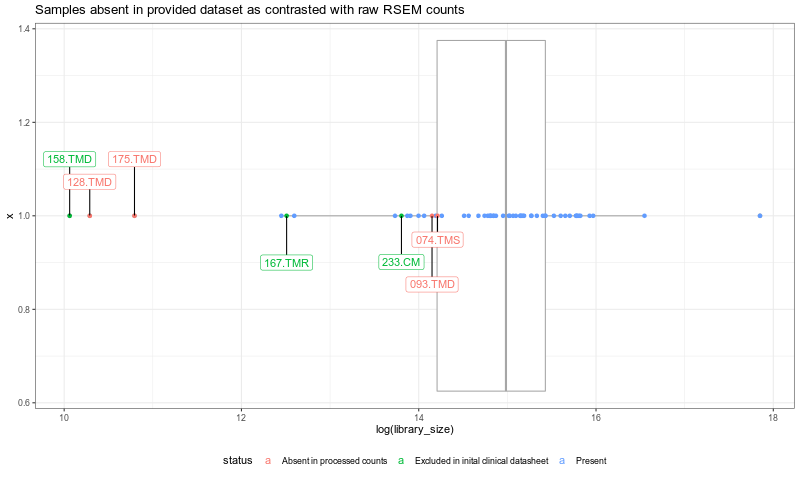

In [42]:
%%R -i sizes -w 800
set.seed(0)
(
    ggplot(sizes, aes(x=1, y=log(library_size)))
    + nice_theme
    + geom_boxplot(color='grey65')
    + geom_point(aes(color=status))
    + coord_flip()
    + ggrepel::geom_label_repel(
        data=sizes[sizes$label != '', ],
        aes(color=status, label=label), nudge_x=c(-0.1, 0.1), direction="y", max.overlaps=Inf
    )
    + ggtitle('Samples absent in provided dataset as contrasted with raw RSEM counts')
)

Removal of `158.TMD` seems easily warranted (law library size). Not sure about others though.

While I could deduce the subgroup, I am not certain if I should be using these..
I will discard the three patients without the data for now as it is easier to include them later than rewrite to discard:

In [43]:
without_absent = 'index not in @patients_initially_excluded'

clinical_counts_subset = clinical_counts.query(without_absent)
raw_counts_matrix_subset = raw_counts_matrix.T.query(without_absent).T

In [44]:
c_by_condition = clinical_counts_subset.Meningitis
c_by_condition_and_tb_subset = clinical_counts_subset.Meningitis_with_tuberculosis_status

In [45]:
%R -i c_by_condition -i c_by_condition_and_tb_subset -i raw_counts_matrix_subset

#### Comparison to samples (patients) removed for DESeq2

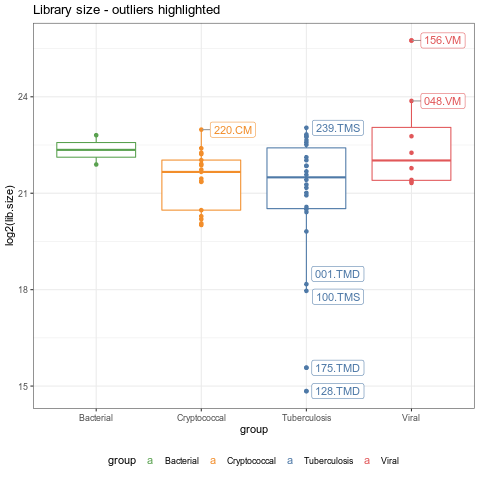

In [46]:
%%R
f_dge <- edgeR::DGEList(counts=raw_counts_matrix_subset, group=c_by_condition)
samples = f_dge$samples
sample_names = remove_leading_X(rownames(samples))
sample_size = log2(samples$lib.size)
samples$sample = ifelse(sample_size > 22.9 | sample_size < 19, sample_names, NA)
(
    ggplot(samples, aes(color=group, x=group, y=log2(lib.size), label=sample))
    + geom_boxplot() + geom_point()
    + ggrepel::geom_label_repel(force=6, nudge_x=0.3, segment.color='grey60')
    + scale_color_manual(values=patient_colors$Meningitis)
    + nice_theme
    + ggtitle('Library size - outliers highlighted')
)

In [47]:
set(raw_counts_matrix.columns) - set(raw_deseq2_matrix.columns)

{'074.TMS', '093.TMD', '128.TMD', '158.TMD', '167.TMR', '175.TMD', '233.CM'}

In [48]:
set(raw_counts_matrix_subset.columns) - set(raw_deseq2_matrix.columns)

{'074.TMS', '093.TMD', '128.TMD', '175.TMD'}

For DESeq2 four samples more were excluded:
- I understand exclusion of `175.TMD` and `128.TMD` (very low library size)
- I was not sure why `093.TMD` and `074.TMS` were excluded; dr Rachel provided criteria as follows:
  - Rows (gene) filter
    - Expression threshold (min. read count) = 1
    - Required percentage (min. percentage of columns/samples required to pass the expression threshold) = 25
  - Column (sample) filter
    - Expression threshold = 1
    - Required percentage (min. percentage of genes required to pass the threshold) = 50

While I was not able to exactly replicate the results in Python, the samples that I filtered using this criteria are a superset of the missing samples, so it seems ok:

In [49]:
gene_filtered = raw_counts_matrix.iloc[list((raw_counts_matrix >= 1).apply(mean, axis=1) >= 0.25),:]
sample_filtered = gene_filtered.iloc[:,list((gene_filtered >= 1).apply(mean) >= 0.5)]
set(raw_counts_matrix_subset.columns) - set(sample_filtered.columns)

{'028.TMR', '043.TMS', '074.TMS', '093.TMD', '128.TMD', '149.TMD', '175.TMD'}

Also, using 40% works:

In [50]:
gene_filtered = raw_counts_matrix.iloc[list((raw_counts_matrix >= 1).apply(mean, axis=1) >= 0.25),:]
sample_filtered = gene_filtered.iloc[:,list((gene_filtered >= 1).apply(mean) >= 0.4)]
set(raw_counts_matrix_subset.columns) - set(sample_filtered.columns)

{'074.TMS', '093.TMD', '128.TMD', '175.TMD'}

Sanity check: there should be no additional samples in the DESeq2 normalized counts:

In [51]:
assert not set(raw_deseq2_matrix.columns) - set(raw_counts_matrix.columns)

#### Outlier detection will be continued

Given low number of samples and the fact that both limma-voom and DESeq2 can correct for the library size I would be conservative in outlier removal and only remove `128.TMD`, `158.TMD` and `175.TMD` based on the very low library sizes; however it seems alarming that all of these belong to TMD group.

A simple hierarchical clustering confirms that these samples group together due to low absolute expression values:

In [52]:
%R library(pheatmap);

In [53]:
from plots.annotations import generate_patient_annotations

In [54]:
clinical_full = clinical_counts
full_by_condition = clinical_full.Meningitis
full_by_condition_and_tb_subset = clinical_full.Meningitis_with_tuberculosis_status

In [55]:
counts_patient_annotations = generate_patient_annotations(clinical_full)

In [56]:
%%R -i counts_patient_annotations

names(counts_patient_annotations) = dot_to_space(names(counts_patient_annotations))
colnames(raw_counts_matrix) <- remove_leading_X(colnames(raw_counts_matrix))

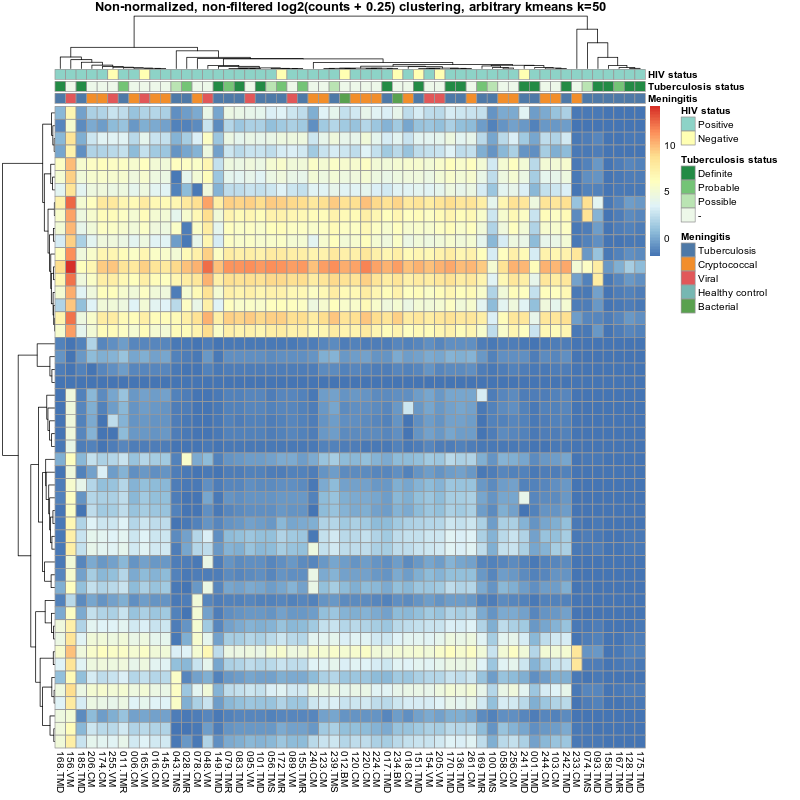

In [57]:
%%R -w 800 -h 800 -i gene_filtered 
set.seed(0)

full_counts_clusters = pheatmap(
    log2(raw_counts_matrix + 0.25),
    show_colnames=T,
    show_rownames=F,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation',
    kmeans_k=50,
    main='Non-normalized, non-filtered log2(counts + 0.25) clustering, arbitrary kmeans k=50'
)

The four columns to the right does not look right...

However, such analysis is not very informative due to library size differences - I will continue with outlier detection using filtered and normalized data.

### Gene filtering

Note: the filtering uses the design vector, thus it might seem that it needs to be repeated for the designs with and without use of the TB subsets (possible, probable, definite).

However, as the filtering procedure uses the criteria based on the smallest number of samples (patients) in each condition, the viral condition is always the smallest (has less patients than each of the TB subgroups) so the filtering result should be the same:

By default `filterByExpr` requires at least 10 (`min.count`) reads (scaled to library size) in at least $n$ samples where $n$ is determined by the number of samples in smallest groups (n >= 70% |size of smallest group|). For us this is $n \ge 0.7 * 8 \approx 6$ samples. Additionally minimum 15 (`min.count.total`) reads per gene are required in total. But is it?

In [58]:
full_by_condition.value_counts()

Tuberculosis    28
Cryptococcal    18
Viral            8
Bacterial        2
Name: Meningitis, dtype: int64

In [59]:
full_by_condition_and_tb_subset.value_counts()

Cryptococcal             18
Definite tuberculosis    16
Viral                     8
Probable tuberculosis     7
Possible tuberculosis     5
Bacterial                 2
Name: Meningitis_with_tuberculosis_status, dtype: int64

The problem is that using the current design there are also two other bacterial samples, which reduce the samples count threshold (instead of \*8 we have just \*2), which makes the filtering less stringent.

In [60]:
%%R -i full_by_condition -i full_by_condition_and_tb_subset
c_dge <- edgeR::DGEList(counts=raw_counts_matrix, group=full_by_condition)
c_dge_subset <- edgeR::DGEList(counts=raw_counts_matrix, group=full_by_condition_and_tb_subset)

import::here(filter_out_low_expression, .from='helpers/differential_expression.R')

Therefore, I opt to modify the design at this point to trick `filterByExpr` to calculate $n$ as $\ge 0.7 * 8$:

In [61]:
dummy_condition_vector = full_by_condition.replace('Bacterial', 'Tuberculosis')

In [62]:
dummy_condition_vector_for_subet = full_by_condition_and_tb_subset.replace('Bacterial', 'Definite tuberculosis')

In [63]:
min(dummy_condition_vector.value_counts())

8

In [64]:
min(dummy_condition_vector_for_subet.value_counts())

5

In [65]:
%%R -i dummy_condition_vector
c_dge_tb_together_filtered = filter_out_low_expression(c_dge, dummy_condition_vector);

[1] "Retaining: 50.51%"


In [66]:
%%R -i dummy_condition_vector_for_subet
c_dge_tb_subsets_filtered = filter_out_low_expression(c_dge_subset, dummy_condition_vector_for_subet);

[1] "Retaining: 58.05%"


Whereas, without the change we would get (the counts are identical as in both cases the bacterial "2" was limiting $n$):

In [67]:
%R c_dge_tb_together_permissively_filtered = filter_out_low_expression(c_dge, full_by_condition);

[1] "Retaining: 71.59%"


In [68]:
%R c_dge_tb_subsets_permissively_filtered = filter_out_low_expression(c_dge_subset, full_by_condition_and_tb_subset);

[1] "Retaining: 71.59%"


In other words, I will use the bacterial group to improve the trend predictions, but not for filtering as this is not a group of primary interest.

This provides a nice mean-variance relation plot (which is not as good when using less stringent filtering with the bacterial group):

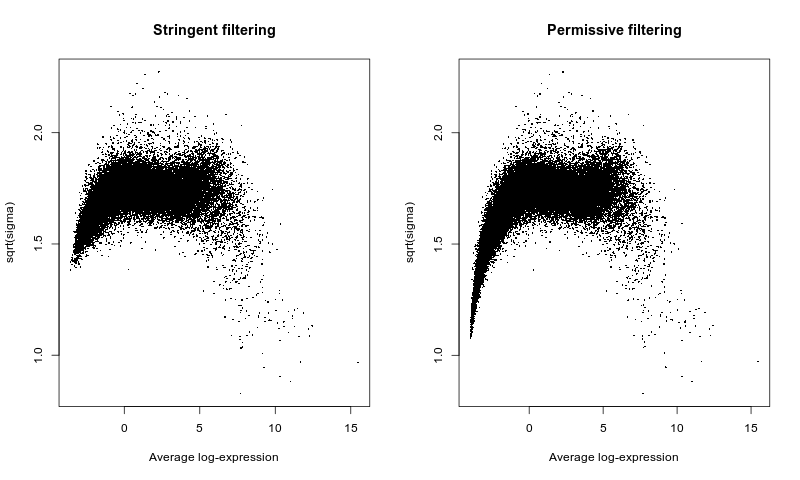

In [69]:
%%R -w 800
par(mfrow=c(1,2))

logCPM <- edgeR::cpm(c_dge_tb_subsets_filtered, log=TRUE, prior.count=0.25)
raw_fit = limma_fit(data=logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(raw_fit)
title('Stringent filtering')


logCPM <- edgeR::cpm(c_dge_tb_subsets_permissively_filtered, log=TRUE, prior.count=0.25)
raw_fit = limma_fit(data=logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(raw_fit)
title('Permissive filtering')

The "niceness" is defined by the lack of the initial turn of the relation to the left-down corner (i.e. the genes with little reads which are less variable due to numerical properties (negative binomial) do not misguide the relation). See [this comment](https://support.bioconductor.org/p/85511/#85639) for intuition.

Note: the approach mentioned [here](https://support.bioconductor.org/p/85511/#85514) has been recently (well, two years ago - 2017) automated in edgeR and roughly corresponds to `edgeR::filterByExpr`.

There were below 6000 raw counts:

In [70]:
len(raw_counts_matrix)

58233

The dataset provided to DESeq2 was filtered to:

In [71]:
len(raw_deseq2_matrix)

38664

And our strict filtering gives comparable results (with slightly fewer genes remaining):

In [72]:
%R nrow(c_dge_tb_subsets_filtered$counts)

array([33804], dtype=int32)

In [73]:
%R nrow(c_dge_tb_together_filtered$counts)

array([29411], dtype=int32)

### The outlier to the right

We still have an outlier here (at 15) as we only filtered out the lowly expressed genes. Now, can we remove it? Is it of any benefit?
- Rather not, as I use "robust" version and the limma's author agues it is robust enough [link]
- Maybe, because this outlier may affect the trend estimate

TODO: I lost the link!

So what do we see exactly?

In [74]:
%%R
l = rowMeans(logCPM)
head(l[l > 15])

ENSG00000251562 
       15.48669 


In [75]:
from helpers.ensembl import Ensembl

ensembl = Ensembl(95)
get_gene = ensembl.get_gene

In [76]:
ensembl.gene_by_id('ENSG00000251562')

Gene(gene_id='ENSG00000251562', gene_name='MALAT1', biotype='lincRNA', contig='11', start=65497688, end=65506516, strand='+', genome='GRCh38')

I've got no idea why.. Is this condition-dependent anyhow?

In [77]:
%%R
malat1 = data.frame(
    condition=full_by_condition_and_tb_subset,
    malat1=logCPM['ENSG00000251562',]
)

In [78]:
%R head(malat1)

condition     malat1
001.TMD  Definite tuberculosis  15.945300
006.CM            Cryptococcal  14.883386
012.BM               Bacterial  15.734177
016.CM            Cryptococcal  15.659558
017.TMD  Definite tuberculosis  16.132236
018.CM            Cryptococcal  15.930723

notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.


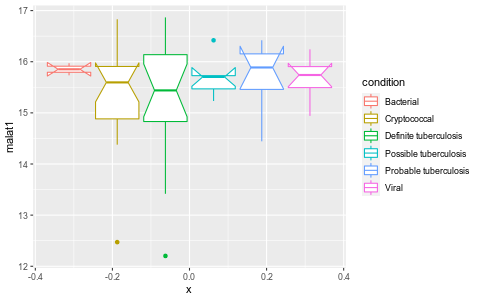

In [79]:
%%R -h 300
ggplot(malat1, aes(y=malat1, color=condition, x=0)) + geom_boxplot(notch=T)

(looking at notches) we cannot confidently say that this is differential.

Was it included in DESeq2 processed dataset?

In [80]:
'ENSG00000251562' in set(raw_deseq2_matrix.reset_index().ensembl_id)

True

Will this **really** improve the trend if we remove it?

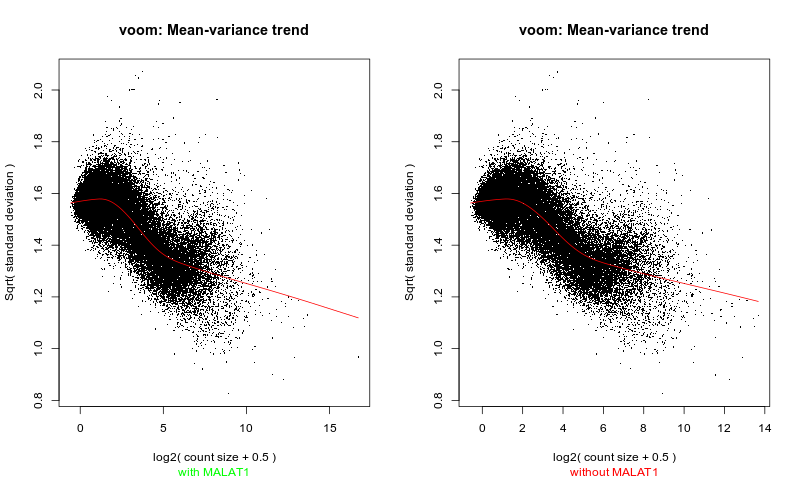

In [81]:
%%R -w 800
c_dge_ts_f <- c_dge_tb_subsets_filtered

dge_without_outlier = c_dge_ts_f[rownames(c_dge_ts_f) != 'ENSG00000251562',]
design = design_from_conditions(full_by_condition_and_tb_subset)
par(mfrow=c(1,2))
v = limma::voom(c_dge_ts_f, design, plot=TRUE); title(sub='with MALAT1', col.sub='green')
v = limma::voom(dge_without_outlier, design, plot=TRUE); title(sub='without MALAT1', col.sub='red')

No, not really - just a little bit.

### Normalization

Adding TMM normalization/scaling factors:

In [82]:
%%R
c_dge_tb_subsets_filtered_norm <- edgeR::calcNormFactors(c_dge_tb_subsets_filtered)
c_dge_tb_together_filtered_norm <- edgeR::calcNormFactors(c_dge_tb_together_filtered) 

### Transformation

Note: if we were to lowering the `prior.count`, the "stripy" pattern will emerge (I suspect that it highlights individual counts - uncovering discretization):

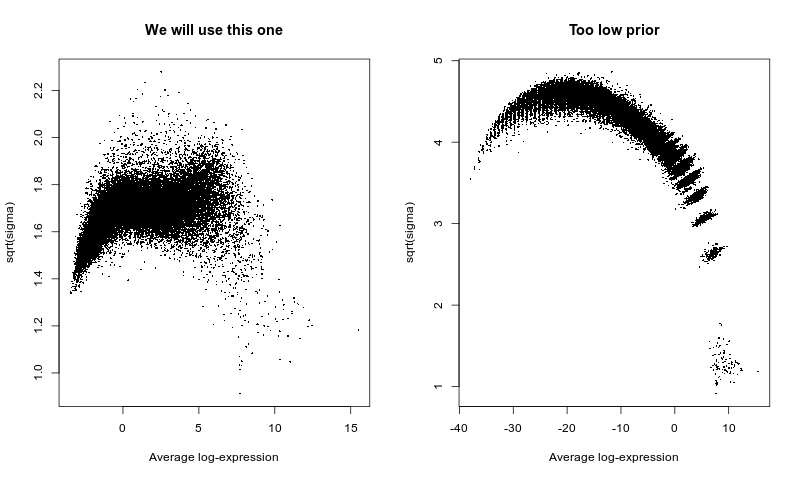

In [83]:
%%R -w 800
par(mfrow=c(1,2))

c_dge_ts_f_n <- c_dge_tb_subsets_filtered_norm

logCPM <- edgeR::cpm(c_dge_ts_f_n, log=TRUE, prior.count=0.25)
raw_fit = limma_fit(data=logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(raw_fit); title('We will use this one')
        
low_logCPM <- edgeR::cpm(c_dge_ts_f_n, log=TRUE, prior.count=0.000000000001)
low_raw_fit = limma_fit(data=low_logCPM, conditions_vector=full_by_condition_and_tb_subset, a='Definite tuberculosis', b='Cryptococcal')
limma::plotSA(low_raw_fit); title('Too low prior')

### Outlier detection continued

TODO: due to lack of clinical annotations for three samples I am using trimmed data here - this will be updated on Wednesday

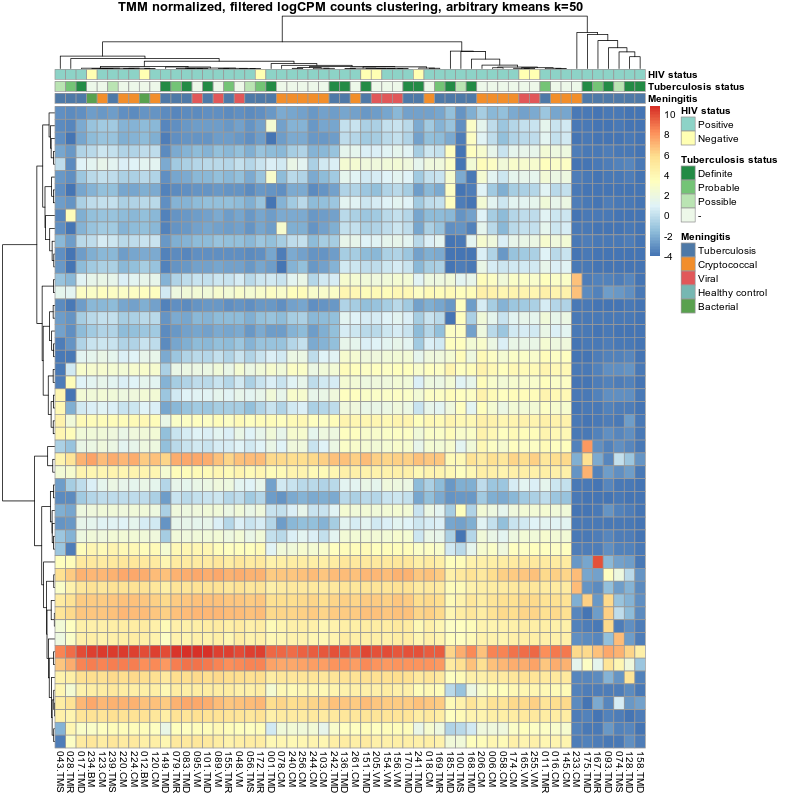

In [84]:
%%R -w 800 -h 800
set.seed(0)

full_counts_clusters = pheatmap(
    logCPM,
    show_colnames=T,
    show_rownames=F,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation',
    kmeans_k=50,
    main='TMM normalized, filtered logCPM counts clustering, arbitrary kmeans k=50'
)

The divergence of the samples: 175, 074, 093, 128, 158, 233 supports the case for their removal.

In [85]:
%R library(factoextra);

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


In [86]:
%%R
pca = prcomp(t(logCPM), scale=F)

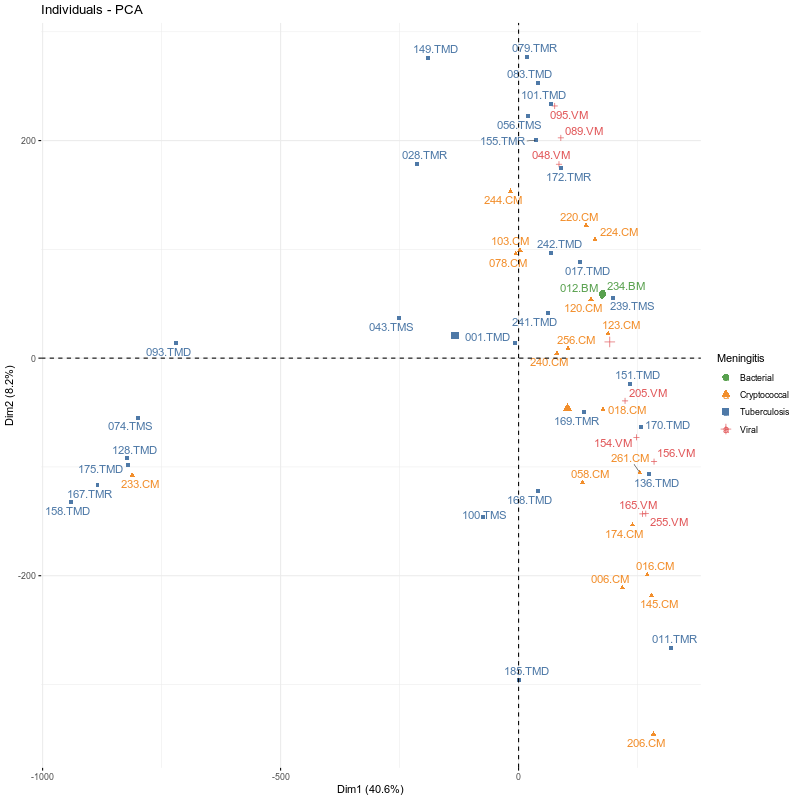

In [87]:
%%R -w 800 -h 800 -u px
fviz_pca_ind(
    pca,
    repel=T,
    col.ind=counts_patient_annotations[colnames(logCPM), ]$Meningitis,
    palette=patient_colors$Meningitis
) +  guides(shape=guide_legend(title='Meningitis'), color=guide_legend(title='Meningitis'))

And PCA agrees.

[Some](https://www.biostars.org/p/281767/#281827) recommend |z-score| > 3 for outlier detection. The proposed outliers do not meet this threshold - though they are clearly above two standard deviations away:

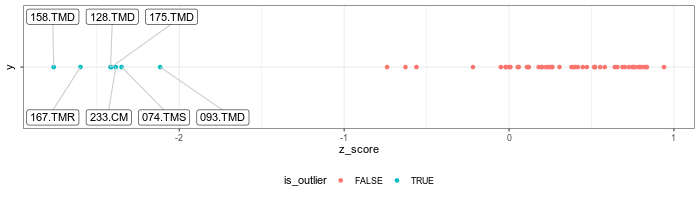

In [88]:
%%R -h 200 -w 700
df = data.frame(z_score=scale(pca$x)[,'PC1'], sample=rownames(pca$x))
df$is_outlier = abs(df$z_score) > 2
(
    ggplot(df, aes(x=z_score, label=sample, y='', color=is_outlier))
    + geom_point()
    + ggrepel::geom_label_repel(data=df[df$is_outlier, ], nudge_y=c(-1, 1), segment.color='grey80', color='black')
    + nice_theme
)

#### What if we change the normalization method?

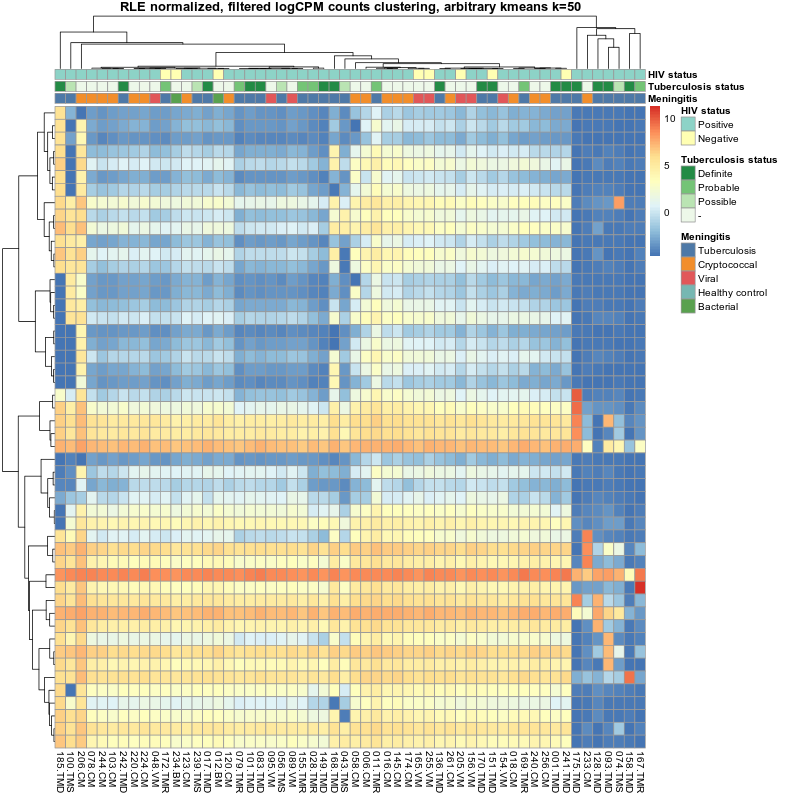

In [89]:
%%R -w 800 -h 800

dge_norm_as_if_dseq2 <- edgeR::calcNormFactors(c_dge_tb_subsets_filtered, method='RLE')
cpm_norm_as_if_dseq2 <- edgeR::cpm(dge_norm_as_if_dseq2, log=TRUE, prior.count=0.25)
        
set.seed(0)

full_counts_clusters = pheatmap(
    cpm_norm_as_if_dseq2,
    show_colnames=T,
    show_rownames=F,
    annotation_col=counts_patient_annotations,
    annotation_colors=patient_colors,
    clustering_method='ward.D2',
    clustering_distance_cols='correlation',
    clustering_distance_rows='correlation',
    kmeans_k=50,
    main='RLE normalized, filtered logCPM counts clustering, arbitrary kmeans k=50'
)

TODO: Treatment status!

The outliers are still visible.

### Removing 175.TMD, 074.TMS, 093.TMD, 128.TMD, 158.TMD, 167.TMR and 233.CM

In [90]:
%%R -o outliers
outliers = c('175.TMD', '074.TMS', '093.TMD', '128.TMD', '158.TMD', '167.TMR', '233.CM')
is_outlier = colnames(c_dge_subset) %in% outliers

raw_counts_matrix_no_outliers = raw_counts_matrix[,!is_outlier]

c_dge_tb_subsets_filtered_norm_no_outliers = c_dge_tb_subsets_filtered_norm[,!is_outlier]
c_dge_tb_together_filtered_norm_no_outliers = c_dge_tb_together_filtered_norm[,!is_outlier]

by_condition_no_outliers = full_by_condition[!is_outlier]
by_condition_and_tb_subset_no_outliers = full_by_condition_and_tb_subset[!is_outlier]

print(paste0('Removed ', mean(is_outlier) * 100, '% samples as outliers'))

[1] "Removed 12.5% samples as outliers"


In [91]:
clinical_counts['is_rna_outlier'] = clinical_counts.index.isin(outliers)

In [92]:
data = clinical_counts[['censored_survival', 'Sex', 'CSFGlucose', 'Protein', 'is_rna_outlier', 'AntiTB', 'SteroidsStarted', 'Death', 'Meningitis', 'RCC', 'WCC', '%Neutro', '%Lympho', 'TBMGrade']]

In [93]:
%%R -i data
library("survminer")
library("survival")
source('helpers/survival.R')

Loading required package: ggpubr
Loading required package: magrittr


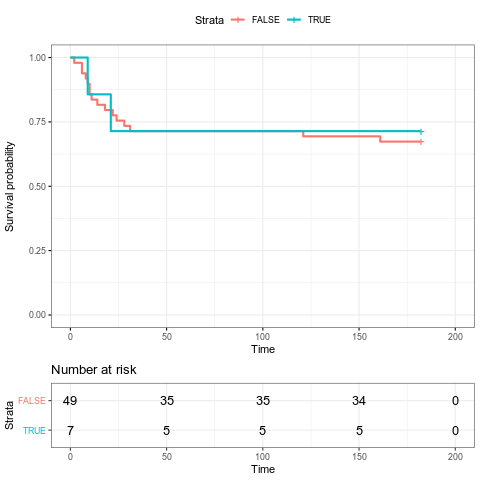

In [94]:
%%R -o fit
fit <- survfit(Surv(data$censored_survival, data$Death) ~ is_rna_outlier, data=data)
strata = strip_strata_prefix(fit)

ggsurvplot(
    fit, data=data,
    legend.labs=strata,
    risk.table=T, ggtheme=theme_bw()
)

In [95]:
%%R
x = data[data$Meningitis == 'Tuberculosis',]
x = x[, complete.cases(t(x))]
x = Filter(var, x)
x = type.convert(x, as.is=T)

corrplot 0.84 loaded


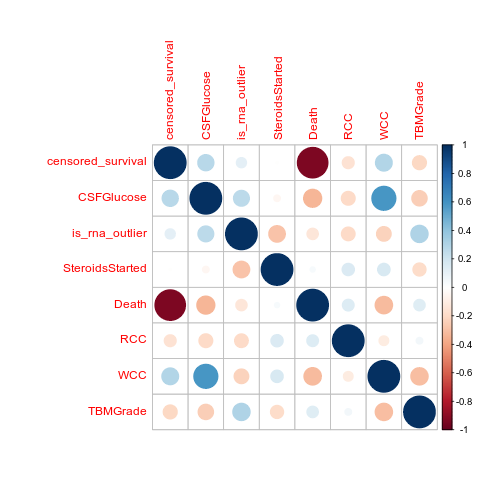

In [96]:
%%R
library(corrplot)
correlations <- cor(x)
corrplot(correlations, method="circle")

In [97]:
%%R
# death and survival obviously too corelated; WCC/CSFGlucose - close!
selection = subset(x, select=-c(Death))
summary(lm(is_rna_outlier ~ ., data=selection))


Call:
lm(formula = is_rna_outlier ~ ., data = selection)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61740 -0.23003 -0.01822  0.10483  0.75196 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)  
(Intercept)         -0.3681857  0.3749918  -0.982   0.3374  
censored_survival    0.0008521  0.0010295   0.828   0.4172  
CSFGlucose           0.1820418  0.0700032   2.600   0.0167 *
SteroidsStartedTRUE -0.1206518  0.2067015  -0.584   0.5656  
RCC                 -0.0014824  0.0023108  -0.642   0.5281  
WCC                 -0.0009280  0.0004126  -2.249   0.0353 *
TBMGrade             0.2232207  0.1299867   1.717   0.1006  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3621 on 21 degrees of freedom
Multiple R-squared:  0.4158,	Adjusted R-squared:  0.2489 
F-statistic: 2.491 on 6 and 21 DF,  p-value: 0.05595



For a plot, see below logistic regression.

In [98]:
%%R
summary(glm(is_rna_outlier ~., family=binomial(link='logit'), data=selection))


Call:
glm(formula = is_rna_outlier ~ ., family = binomial(link = "logit"), 
    data = selection)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.85691  -0.36555  -0.06684   0.00000   1.93056  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)  
(Intercept)         -9.219768   5.306774  -1.737   0.0823 .
censored_survival    0.002562   0.011193   0.229   0.8189  
CSFGlucose           2.076905   1.223718   1.697   0.0897 .
SteroidsStartedTRUE -1.373669   1.731629  -0.793   0.4276  
RCC                 -0.387524   0.475437  -0.815   0.4150  
WCC                 -0.003655   0.005353  -0.683   0.4948  
TBMGrade             2.861555   1.863328   1.536   0.1246  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 29.096  on 27  degrees of freedom
Residual deviance: 14.538  on 21  degrees of freedom
AIC: 28.538

Number of Fisher Scoring iterations: 

In [99]:
# sometimes fighting with the rpy2 conversions is not worth it: 
tmp_clinical_path = '/tmp/clinical_counts_with_rna_outliers.csv'
clinical_counts.to_csv(tmp_clinical_path)

In [100]:
%%R -i tmp_clinical_path
df = read.csv(tmp_clinical_path, row.names=1, check.names=FALSE)
names(df) = sub('%', 'Percent_', names(df))
df = df[df$Meningitis=='Tuberculosis',]
df$observation_type = ifelse(as.logical(df$is_rna_outlier), 'RNA outlier TB', 'Non-outlier TB')

notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went o

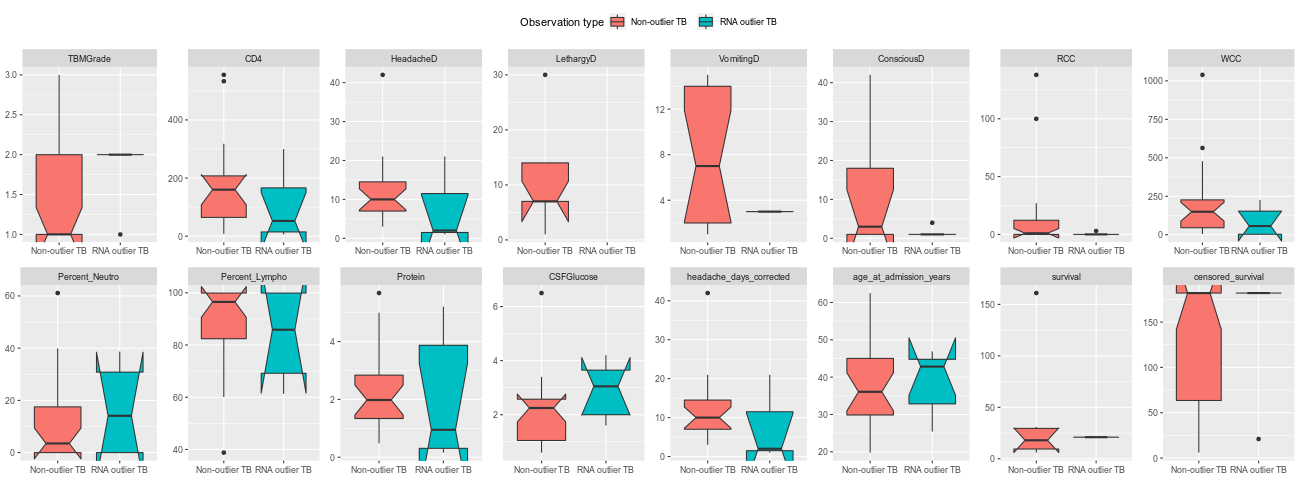

In [101]:
%%R -w 1300
import::here(ggplot_columns_grid, .from='plots/grids.R')

ggplot_columns_grid(
    df,
    ggplot=function(data, column) {(
        ggplot(data, aes_string(x='observation_type', y=column, fill='observation_type', group='observation_type'))
        + geom_boxplot(notch=T)
    )},
    prepare_legend=function(legend) {
        legend + guides(fill=guide_legend(title='Observation type'))
    }
)

### Wrapping up

Repeat preprocessing, this time without outliers:

In [102]:
%%R
import::here(calc_normalization_factors, .from='helpers/preprocessing.R')

preprocess_limma = function(counts, conditions, strict_filter_join_bacterial_to=F, method='TMM', ...) {
    dge = edgeR::DGEList(counts=counts, group=conditions)

    if (strict_filter_join_bacterial_to != F)
        conditions[conditions=='Bacterial'] = strict_filter_join_bacterial_to

    dge_filtered = filter_out_low_expression(dge, conditions)
    calc_normalization_factors(dge_filtered, method=method, ...)
}

In [103]:
%%R
clean_dge_tb_together = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis')
clean_dge_tb_subset = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis')

[1] "Retaining: 51.74%"
[1] "Retaining: 62.63%"


### Helper functions

In [104]:
from helpers.venn import venn2, venn3, venn4, venn_n

In [105]:
with_gene_data = partial(ensembl.merge_gene_data, sort='adj.P.Val')

### Enabling Gene Set Enrichment Analysis

In [106]:
ensembl_to_entrez = read_csv(ensembl_to_entrez_path, index_col=0)
ensembl_to_entrez.head(2)

NCBI Gene ID
Ensembl gene ID              
ENSG00000121410             1
ENSG00000268895        503538

In [107]:
from helpers.gse import collection_to_R, nice_kegg, formatter_to_fix_letter_case
from gsea_api.molecular_signatures_db import MolecularSignaturesDatabase, GeneMatrixTransposed

db = MolecularSignaturesDatabase('data/msigdb', version='6.2')

In [108]:
reactome_new_symbol = GeneMatrixTransposed.from_gmt('data/ReactomePathways.gmt', name='reactome_new_symbol')
kegg_pathways_entrez = db.load(gene_sets='c2.cp.kegg', id_type='entrez').format_names(nice_kegg)
reactome_pathways_entrez = db.load(gene_sets='c2.cp.reactome', id_type='entrez').format_names(
    formatter_to_fix_letter_case(reactome_new_symbol)
)

/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:61: UserWarning: Provided gene sets are not redundant; there are 117 gene sets having more than one name assigned; use find_redundant() to investigate further.
  warn(message)


In [109]:
ensembl_to_gene_name = ensembl.merge_gene_data(raw_counts_matrix)[['gene_name']]

In [110]:
i = set(ensembl_to_entrez.index)

entrez_ids = {
    str(int(ensembl_to_entrez.loc[g])) for g in raw_counts_matrix_subset.index
    if g in i
}

mapped = set(raw_counts_matrix.index) & set(ensembl_to_gene_name.index)

symbols = set(ensembl_to_gene_name.loc[list(mapped)]['gene_name'])

for collection, genes in [
    (kegg_pathways_entrez, entrez_ids),
    (reactome_pathways_entrez, entrez_ids),
    (reactome_new_symbol, symbols)
]:
    after_trimming = collection_to_R(collection, trim_to=genes)
    print(collection.name, len(after_trimming))

c2.cp.kegg 186
c2.cp.reactome 670


/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'Defective GIF causes intrinsic factor deficiency' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'vRNA Synthesis' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'Tolerance by Mtb to nitric oxide produced by macrophages' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/envs/meningitis/lib/python3.7/site-packages/gsea_api/molecular_signatures_db.py:20: UserWarning: GeneSet 'Tolerance of reactive oxygen produced by macrophages' is empty
  warn(f'GeneSet {repr(name)} is empty')
/home/krassowski/.pyenv/versions/3.7.6/env

reactome_new_symbol 1698


### The differential expression analysis and GSEA procedures

In [111]:
%%R
import::here(calc_camera, calc_de, camera_with_statistic, .from='helpers/differential_expression.R')

#### Sanity check: are the Camera/CameraPR results comparable?

In [112]:
%%R -o cam -o cam_pr
cam = calc_camera('Tuberculosis', 'Cryptococcal', c_dge_tb_together_filtered_norm_no_outliers, by_condition_no_outliers, voom=T)
cam_pr = calc_camera('Tuberculosis', 'Cryptococcal', c_dge_tb_together_filtered_norm_no_outliers, by_condition_no_outliers, voom=T, statistic='t')

In [113]:
cam.head(n=10)

NGenes Direction  \
FCERI mediated NF-kB activation                      133.0        Up   
Signaling by the B Cell Receptor (BCR)               160.0        Up   
Fc epsilon receptor (FCERI) signaling                185.0        Up   
FCERI mediated Ca+2 mobilization                      84.0        Up   
Role of LAT2/NTAL/LAB on calcium mobilization         69.0        Up   
FCGR activation                                       71.0        Up   
Antigen activates B Cell Receptor (BCR) leading...    81.0        Up   
FCERI mediated MAPK activation                        85.0        Up   
Interferon alpha/beta signaling                       67.0        Up   
CD22 mediated BCR regulation                          56.0        Up   

                                                          PValue           FDR  
FCERI mediated NF-kB activation                     1.544709e-14  2.622916e-11  
Signaling by the B Cell Receptor (BCR)              9.765169e-14  8.290628e-11  
Fc epsilon receptor (FCERI) signaling               1.963220e-13  1.111182e-10  
FCERI mediated Ca+2 mobilization                    4.126192e-13  1.751568e-10  
Role of LAT2/NTAL/LAB on calcium mobilization       6.777535e-13  1.949373e-10  
FCGR activation                                     6.888243e-13  1.949373e-10  
Antigen activates B Cell Receptor (BCR) leading...  3.199626e-12  7.761378e-10  
FCERI mediated MAPK activation                      4.900921e-12  1.040221e-09  
Interferon alpha/beta signaling                     6.119763e-12  1.154595e-09  
CD22 mediated BCR regulation                        7.412169e-12  1.258586e-09

In [114]:
cam_pr.head(n=10)

NGenes Direction  \
FCERI mediated NF-kB activation                      133.0        Up   
Signaling by the B Cell Receptor (BCR)               160.0        Up   
Fc epsilon receptor (FCERI) signaling                185.0        Up   
Interferon alpha/beta signaling                       67.0        Up   
FCERI mediated Ca+2 mobilization                      84.0        Up   
Ub-specific processing proteases                     174.0        Up   
Role of LAT2/NTAL/LAB on calcium mobilization         69.0        Up   
FCGR activation                                       71.0        Up   
Antigen activates B Cell Receptor (BCR) leading...    81.0        Up   
FCERI mediated MAPK activation                        85.0        Up   

                                                          PValue           FDR  
FCERI mediated NF-kB activation                     5.576130e-13  9.468270e-10  
Signaling by the B Cell Receptor (BCR)              2.025443e-12  1.719601e-09  
Fc epsilon receptor (FCERI) signaling               3.322449e-12  1.880506e-09  
Interferon alpha/beta signaling                     5.488534e-12  2.329883e-09  
FCERI mediated Ca+2 mobilization                    8.350073e-11  2.835685e-08  
Ub-specific processing proteases                    1.422052e-10  4.024407e-08  
Role of LAT2/NTAL/LAB on calcium mobilization       2.322169e-10  5.528136e-08  
FCGR activation                                     2.604540e-10  5.528136e-08  
Antigen activates B Cell Receptor (BCR) leading...  4.949510e-10  9.338075e-08  
FCERI mediated MAPK activation                      5.825666e-10  9.891981e-08

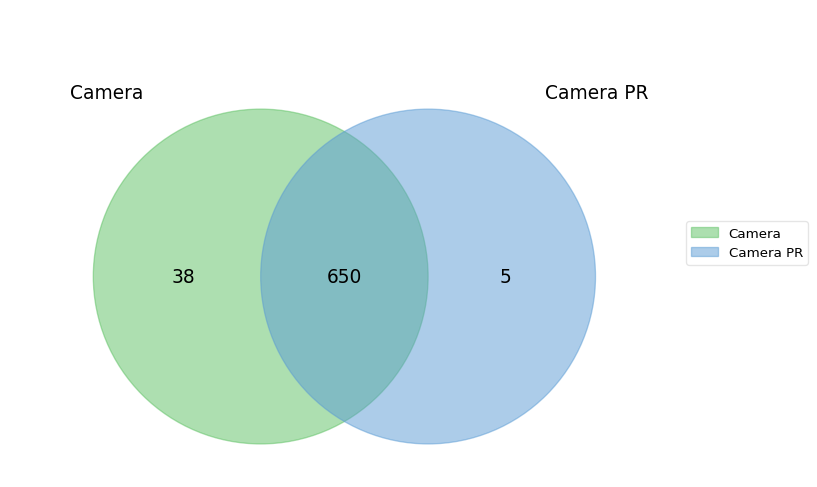

In [115]:
venn2({
    'Camera': cam.query('FDR < 0.05').index,
    'Camera PR': cam_pr.query('FDR < 0.05').index
});

Yes!

#### How much does pre-processing without outliers change?

In [116]:
%R head(calc_de('Tuberculosis', 'Cryptococcal', c_dge_tb_together_filtered_norm_no_outliers, by_condition_no_outliers))

logFC   AveExpr         t   P.Value  adj.P.Val         B
ENSG00000241313 -3.827504  0.103471 -4.957357  0.000006   0.082776  3.424716
ENSG00000280809 -3.687482 -0.392448 -4.932004  0.000007   0.082776  3.347667
ENSG00000179412 -4.027153 -1.742398 -4.882371  0.000008   0.082776  3.197210
ENSG00000272975 -3.837146 -0.400797 -4.617754  0.000022   0.128365  2.404251
ENSG00000264714 -3.895521  0.800231 -4.506954  0.000032   0.128365  2.077294
ENSG00000266486 -3.579099 -1.294764 -4.479094  0.000035   0.128365  1.995594

In [117]:
%R head(calc_de('Tuberculosis', 'Cryptococcal', clean_dge_tb_together, by_condition_no_outliers))

logFC   AveExpr         t   P.Value  adj.P.Val         B
ENSG00000179412 -3.991675 -1.786685 -4.876905  0.000008   0.094880  3.163871
ENSG00000241313 -3.747306  0.052287 -4.872974  0.000008   0.094880  3.152021
ENSG00000280809 -3.616073 -0.452191 -4.840729  0.000009   0.094880  3.054926
ENSG00000272975 -3.768405 -0.454152 -4.580700  0.000024   0.152636  2.280743
ENSG00000264714 -3.831536  0.742310 -4.477572  0.000034   0.152636  1.978430
ENSG00000266486 -3.532354 -1.350692 -4.465795  0.000036   0.152636  1.944091

Not much. But this may be more statistically sound (e.g. when assuming that the rejected samples carry technical error burden).

In [118]:
def limma_venn(limma_gene_sets):
    return venn_n(limma_gene_sets, names=['limma-' + name.replace('_', ' ') for name in limma_gene_sets], n=len(limma_gene_sets))

In [119]:
%R import::here(volcano_plot, .from='plots/volcano.R')

## Comparison of limma-trend, limma-voom and DESeq2

I will be using robust voom with sample quality weights. I will also demonstrate effects of different normalization methods (RLE and TMM) but I will continue using TMM which is standard for limma toolkit.

I will also use independent filtering to limit the effect of lowly expressed genes; for the comparison purposes I will start with the same method as used in DESeq2; but for the final analysis I will use a more advanced technique (Independent hypothesis weighting) which does not blatantly reject all lowly expressed genes.

In [120]:
%%R
import::here(
    filter_by_mean_expression, add_p_value_for_filtered_subset,
    weight_by_mean_expression, add_p_value_for_weighted_hypothesis,
    .from='helpers/independent_hypothesis.R'
)

The independent filtering is an interesting way (or trick) of decreasing the FDR/adjusted p-value by disregarding some hypotheses upfront. The criterion used by DESeq2 is having a small number of normalized counts (regardless of the condition). For more details see the plot and explanation in the [DESeq2 vignette](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilttheory).

Thus at the cost of getting a few false negatives, DESeq increases the number of true positives.

The independent filtering can be applied to edgeR's statistical piepline as well ([statquests](https://statquest.org/2017/05/16/statquest-filtering-genes-with-low-read-counts/) by prof Joshua Starmer)

### Tuberculosis (regardless of certainty) vs Cryptococcal

In [121]:
%%R
tmm_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='TMM')
rle_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='RLE')
tcc_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='TMM', test_method='voom', iterations=3)
qtotal_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='qtotal')

[1] "Retaining: 51.74%"
[1] "Retaining: 51.74%"
[1] "Retaining: 51.74%"
Loading required package: DESeq
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading re

In [122]:
%%R
import::here(calc_normalization_factors, .from='helpers/preprocessing.R')

preprocess_limma = function(counts, conditions, strict_filter_join_bacterial_to=F, method='TMM', ...) {
    dge = edgeR::DGEList(counts=counts, group=conditions)

    if (strict_filter_join_bacterial_to != F)
        conditions[conditions=='Bacterial'] = strict_filter_join_bacterial_to

    dge_filtered = filter_out_low_expression(dge, conditions)
    calc_normalization_factors(dge_filtered, method=method, ...)
}

In [123]:
%%R
qtotal_normalized = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='qtotal')
qtotal_normalized_no_scale = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_no_outliers, 'Tuberculosis', method='qtotal', rescale_lib=F)

[1] "Retaining: 51.74%"
[1] "Retaining: 51.74%"


notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.


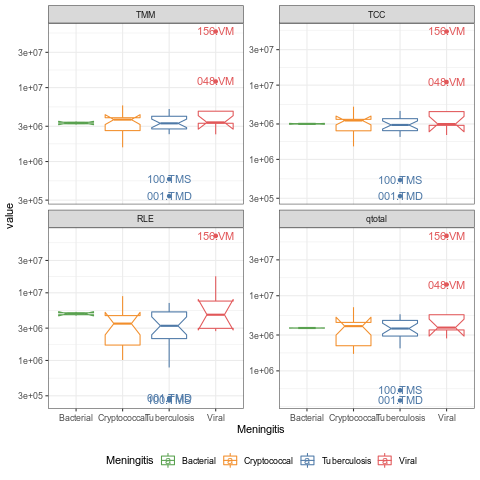

In [124]:
%%R
import::here(label_outliers, .from='plots/utils.R')

size_factors = function(dge) {
    dge$samples$norm.factors * dge$samples$lib.size
}

df = reshape::melt(data.frame(
    TMM=size_factors(tmm_normalized),
    TCC=size_factors(tcc_normalized),
    RLE=size_factors(rle_normalized),
    qtotal=size_factors(qtotal_normalized),
    Meningitis=by_condition_no_outliers,
    patient=as.character(names(by_condition_no_outliers))
), id=c('Meningitis', 'patient'))

(
    ggplot(df, aes(y=value, x=Meningitis, color=Meningitis))
    + facet_wrap('variable', scales='free_y')
    + geom_boxplot(notch=T)
    + nice_theme
    + geom_text(aes(
        label=label_outliers(
            label=patient,
            value=log10(value),
            group=interaction(variable, Meningitis)
        )
    ))
    + color_meningitis
    + scale_y_log10()
)

In [125]:
%%R
import::here(ensembl_to_gene_symbol_named_list, .from='helpers/identifiers_mapping.R')

import::here(
    advanced_differential_expression_heatmap, differential_expression_heatmap,
    significant.limma, significant.deseq,
    .from='plots/differential_expression.R'
)
import::here(compose_title, .from='plots/complex_heatmap.R')


de_heatmap = function(counts, dds, main=NULL, major=NULL, minor=NULL, ...) {
    main = compose_title(main, major, minor)
    advanced_differential_expression_heatmap(counts, dds, ..., main=main, id_to_gene_name=ensembl_to_gene_symbol_named_list)
}

simple_de_heatmap = function(...) {
    differential_expression_heatmap(..., id_to_gene_name=ensembl_to_gene_symbol_named_list)
}

[1] "Retaining: 62.63%"


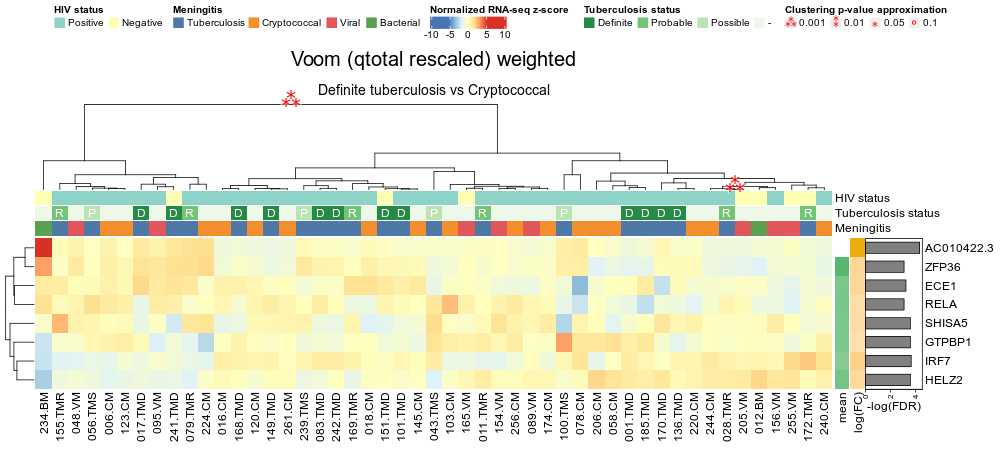

In [126]:
%%R -w 1000 -h 450
qtotal_normalized_tb_subsets = preprocess_limma(
    raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis',
    method='qtotal', rescale_lib=T
)

voom_qtotal = add_p_value_for_weighted_hypothesis(
    calc_de(
        'Definite tuberculosis', 'Cryptococcal', qtotal_normalized_tb_subsets,
        by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T
    )
)

de_heatmap(
    significant.limma(voom_qtotal), qtotal_normalized_tb_subsets,
    major='Voom (qtotal rescaled) weighted',
    minor='Definite tuberculosis vs Cryptococcal',
    r=1 # disable multiscale bootstrap (too few observations)
)

In [127]:
%%R -o qtotal_normalized_tb_subsets_counts
qtotal_normalized_tb_subsets_counts = as.data.frame(qtotal_normalized_tb_subsets$counts)

In [128]:
from scipy.stats import spearmanr

If ECE1 is indeed a proxy of the MTB, we would expect a positive correlation of the value with with the bacterial load, which can be assessed by ordinal relation of the TB subgroups:

In [129]:
tb_ranks = {
    'Definite tuberculosis': 3,
    'Probable tuberculosis': 2,
    'Possible tuberculosis': 1
}

all_ordinal_ranks = {
    **tb_ranks,
    'Bacterial': 0,
    'Cryptococcal': 0,
    'Viral': 0
}

ECE1 = qtotal_normalized_tb_subsets_counts.loc['ENSG00000117298']

spearmanr(
    ECE1.index.map(by_condition_and_tb_subset).map(all_ordinal_ranks),
    ECE1, nan_policy='omit'
)

SpearmanrResult(correlation=0.21638101202647442, pvalue=0.1353532905938852)

In [130]:
%store qtotal_normalized_tb_subsets_counts

Stored 'qtotal_normalized_tb_subsets_counts' (DataFrame)


We can get a bit more statistically sound result if we only look at the TB subgroups - disregarding the Crypto group which was used to nominate this gene in the first place:

In [131]:
spearmanr(
    ECE1.index.map(by_condition_and_tb_subset).map(tb_ranks),
    ECE1, nan_policy='omit'
)

SpearmanrResult(correlation=0.3381452048448578, pvalue=0.12375279739603187)

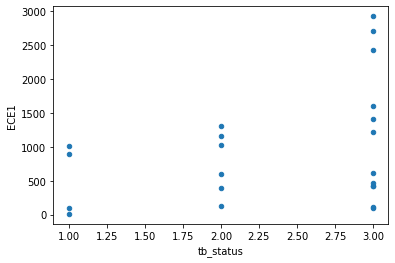

In [132]:
DataFrame(dict(
    tb_status=ECE1.index.map(by_condition_and_tb_subset).map(tb_ranks),
    ECE1=ECE1
)).plot.scatter(x='tb_status', y='ECE1');

[1] "Retaining: 62.63%"


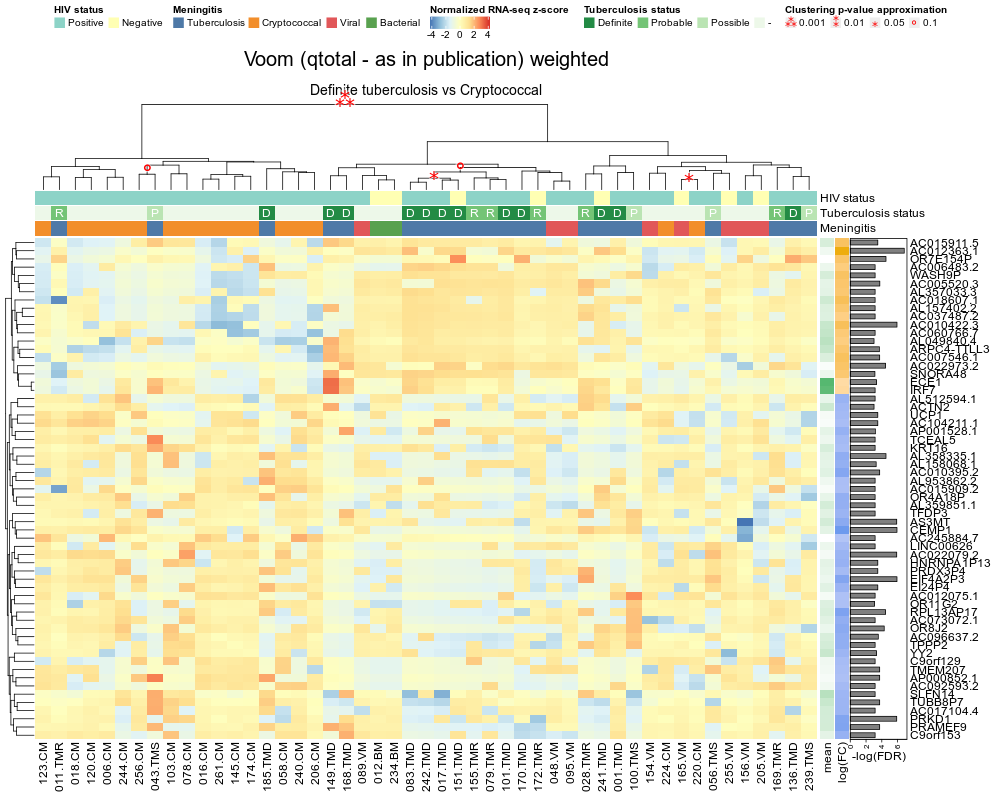

In [133]:
%%R -w 1000 -h 800

qtotal_normalized_tb_subsets = preprocess_limma(
    raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis',
    method='qtotal', rescale_lib=F
)

voom_qtotal = add_p_value_for_weighted_hypothesis(
    calc_de(
        'Definite tuberculosis', 'Cryptococcal', qtotal_normalized_tb_subsets,
        by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T
    )
)

de_heatmap(
    significant.limma(voom_qtotal), qtotal_normalized_tb_subsets,
    major='Voom (qtotal - as in publication) weighted',
    minor='Definite tuberculosis vs Cryptococcal'
)

[1] "Retaining: 62.63%"


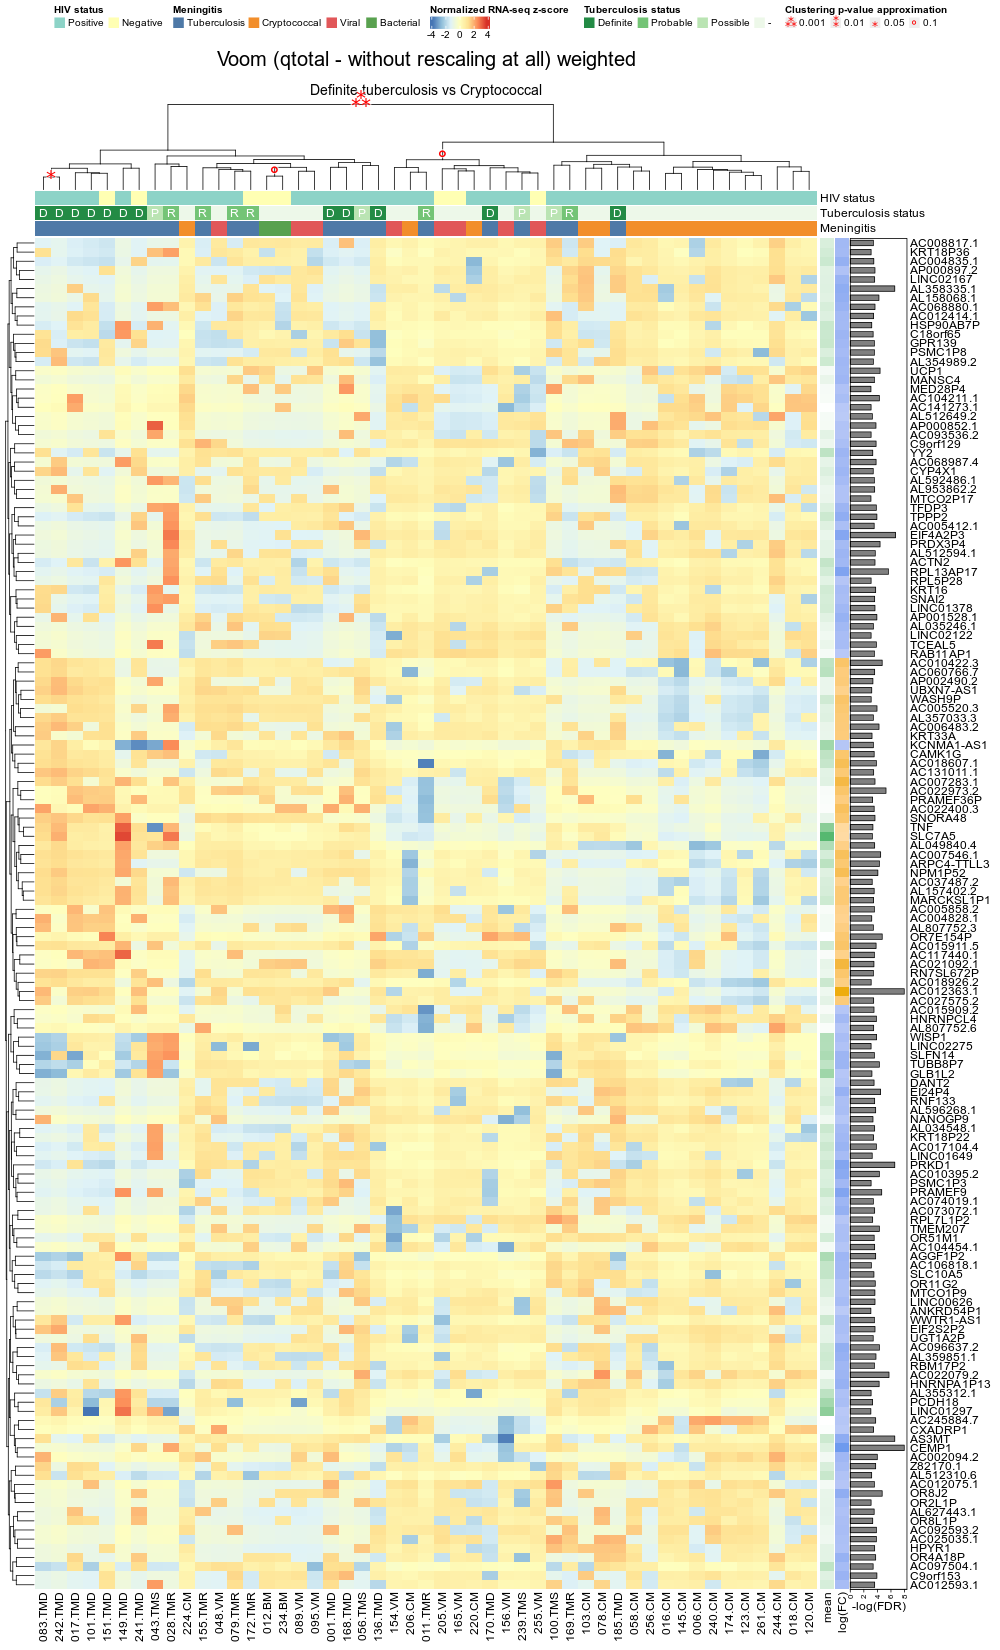

In [134]:
%%R -w 1000 -h 1650
qtotal_normalized_tb_subsets_no_scale_at_all = preprocess_limma(
    raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis',
    method='qtotal', rescale_lib=F, rescale_factor=F
)
voom_qtotal = add_p_value_for_weighted_hypothesis(
    calc_de(
        'Definite tuberculosis', 'Cryptococcal', qtotal_normalized_tb_subsets_no_scale_at_all,
        by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T
    )
)

de_heatmap(
    significant.limma(voom_qtotal), qtotal_normalized_tb_subsets_no_scale_at_all,
    major='Voom (qtotal - without rescaling at all) weighted',
    minor='Definite tuberculosis vs Cryptococcal'
)

In [135]:
%%R -o qtotal_normalized_tb_subsets_no_scale_at_all_counts
qtotal_normalized_tb_subsets_no_scale_at_all_counts = as.data.frame(
    qtotal_normalized_tb_subsets_no_scale_at_all$counts
)

In [136]:
ECE1 = qtotal_normalized_tb_subsets_no_scale_at_all_counts.loc['ENSG00000117298']

spearmanr(
    ECE1.index.map(by_condition_and_tb_subset).map(all_ordinal_ranks),
    ECE1, nan_policy='omit'
)

SpearmanrResult(correlation=0.21638101202647442, pvalue=0.1353532905938852)

I think that there may be a problem with the scaling for heatmap - it may introduce spuriois relations...

But maybe at least some of those are not false postivies - for example ECE1 looks nice:
 - it is related to inflammatory signaling https://www.ncbi.nlm.nih.gov/pubmed/24898255
 - "Mycobacterium tuberculosis Molecular Determinants of Infection, Survival Strategies, and Vulnerable Targets": human ECE-1 shares sequence similarity with MTB Zmp1 which suppresses immune system of the host (caspase-1 activation inhibition).

Why do we so nice pattern? Because this normalization does not use library sizes!
But it is a good normalization otherwise, so I think that it may actually corrected some of the effects... Let's see:

In [137]:
%%R
import::here(calc_normalization_factors, .from='helpers/preprocessing.R')

preprocess_limma = function(counts, conditions, strict_filter_join_bacterial_to=F, method='TMM', ...) {
    dge = edgeR::DGEList(counts=counts, group=conditions)

    if (strict_filter_join_bacterial_to != F)
        conditions[conditions=='Bacterial'] = strict_filter_join_bacterial_to

    dge_filtered = filter_out_low_expression(dge, conditions)
    calc_normalization_factors(dge_filtered, method=method, ...)
}

Indeed, some of the effect may be attributed to the lack of library re-scaling, because as similar effect (but weaker) is seen for TMM normalization (normalization factors stay the same, size factors change due to lack of scale preservation in library sizes estimate):

[1] "Retaining: 62.63%"


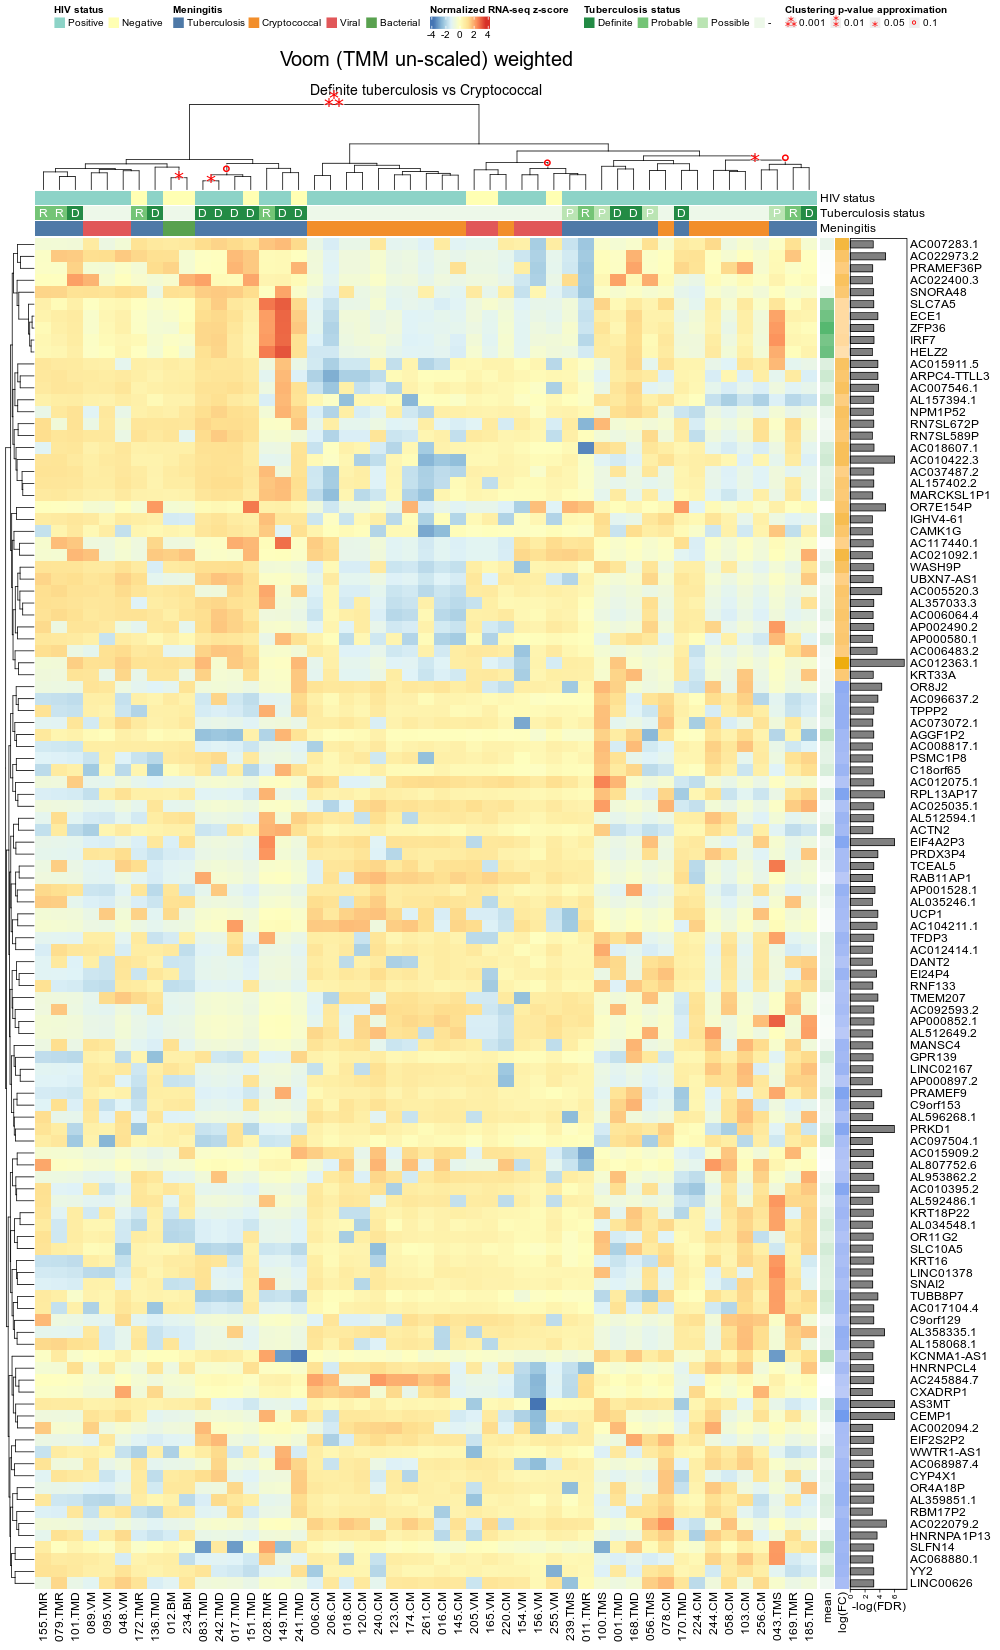

In [138]:
%%R -w 1000 -h 1650
non_normalized_tb_subsets = preprocess_limma(
    raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis',
    method='TMM', rescale_lib=F
)
voom_non_noem = add_p_value_for_weighted_hypothesis(
    calc_de(
        'Definite tuberculosis', 'Cryptococcal', non_normalized_tb_subsets,
        by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T
    )
)

de_heatmap(
    significant.limma(voom_non_noem), non_normalized_tb_subsets,
    major='Voom (TMM un-scaled) weighted',
    minor='Definite tuberculosis vs Cryptococcal'
)

It remains a question whether this scale-dependent effect is only visible in voom (possibly violating some of it's assumptions) or if it also affects other methods.

Some of the picked up genes also show in the anaysis with non-normalization - here the separation is no longer visible:

[1] "Retaining: 62.63%"


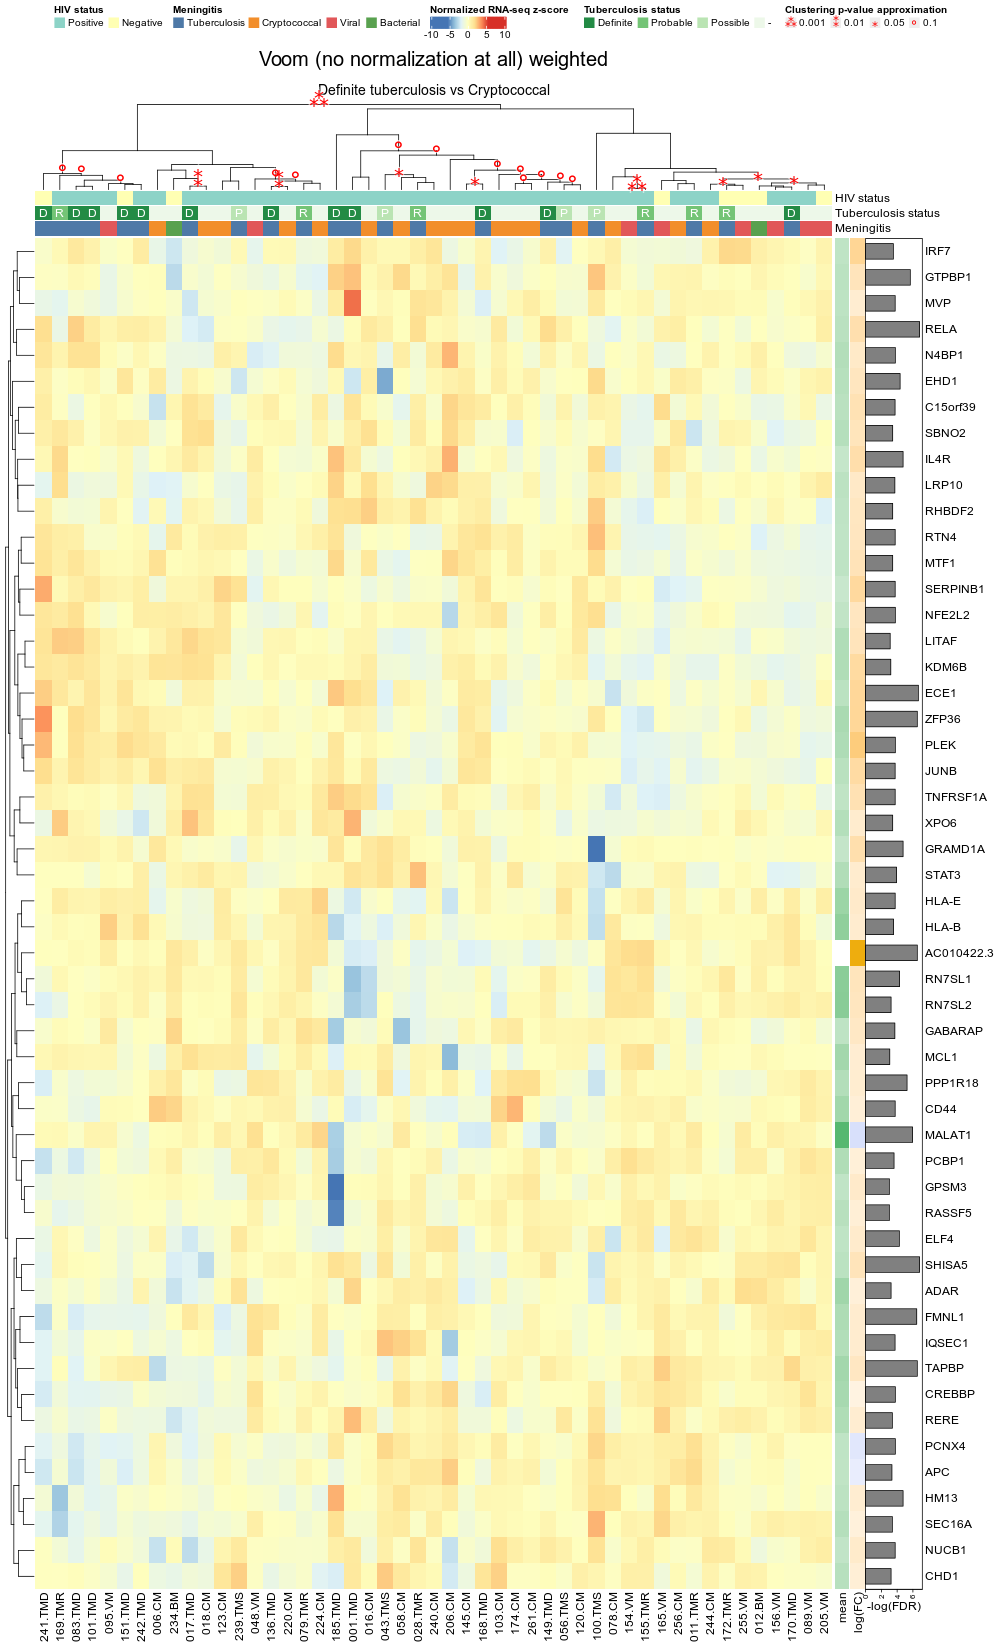

In [139]:
%%R -w 1000 -h 1650
non_normalized_tb_subsets = preprocess_limma(
    raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis',
    method='none'
)
voom_non_noem = add_p_value_for_weighted_hypothesis(
    calc_de(
        'Definite tuberculosis', 'Cryptococcal', non_normalized_tb_subsets,
        by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T
    )
)

de_heatmap(
    significant.limma(voom_non_noem), non_normalized_tb_subsets,
    major='Voom (no normalization at all) weighted',
    minor='Definite tuberculosis vs Cryptococcal'
)

In [140]:
%%R -o trend_tmm -o trend_rle -o voom_rle -o voom_tmm -o trend_tcc -o voom_tcc -o voom_qtotal
trend_tmm = calc_de('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers)
trend_rle = calc_de('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers)
trend_tcc = calc_de('Tuberculosis', 'Cryptococcal', tcc_normalized, by_condition_no_outliers)

voom_rle = calc_de('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers, voom=T, quality_weights=T)
voom_tmm = calc_de('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers, voom=T, quality_weights=T)
voom_tcc = calc_de('Tuberculosis', 'Cryptococcal', tcc_normalized, by_condition_no_outliers, voom=T, quality_weights=T)
voom_qtotal = calc_de('Tuberculosis', 'Cryptococcal', qtotal_normalized, by_condition_no_outliers, voom=T, quality_weights=T)

In [141]:
%%R -o norm_counts
norm_counts = as.data.frame(tmm_normalized$counts)

In [142]:
%store norm_counts

Stored 'norm_counts' (DataFrame)


In [143]:
%store trend_tmm
%store trend_rle
%store voom_rle
%store voom_tmm
%store reference_definite_tbm_cm_deg

Stored 'trend_tmm' (DataFrame)
Stored 'trend_rle' (DataFrame)
Stored 'voom_rle' (DataFrame)
Stored 'voom_tmm' (DataFrame)
Stored 'reference_definite_tbm_cm_deg' (DataFrame)


In [144]:
%R -o reference_samples -o raw_counts_trimmed

In [145]:
%store by_condition_and_tb_subset
%store reference_samples
%store raw_counts_trimmed

Stored 'by_condition_and_tb_subset' (Series)
Stored 'reference_samples' (ndarray)
Stored 'raw_counts_trimmed' (DataFrame)


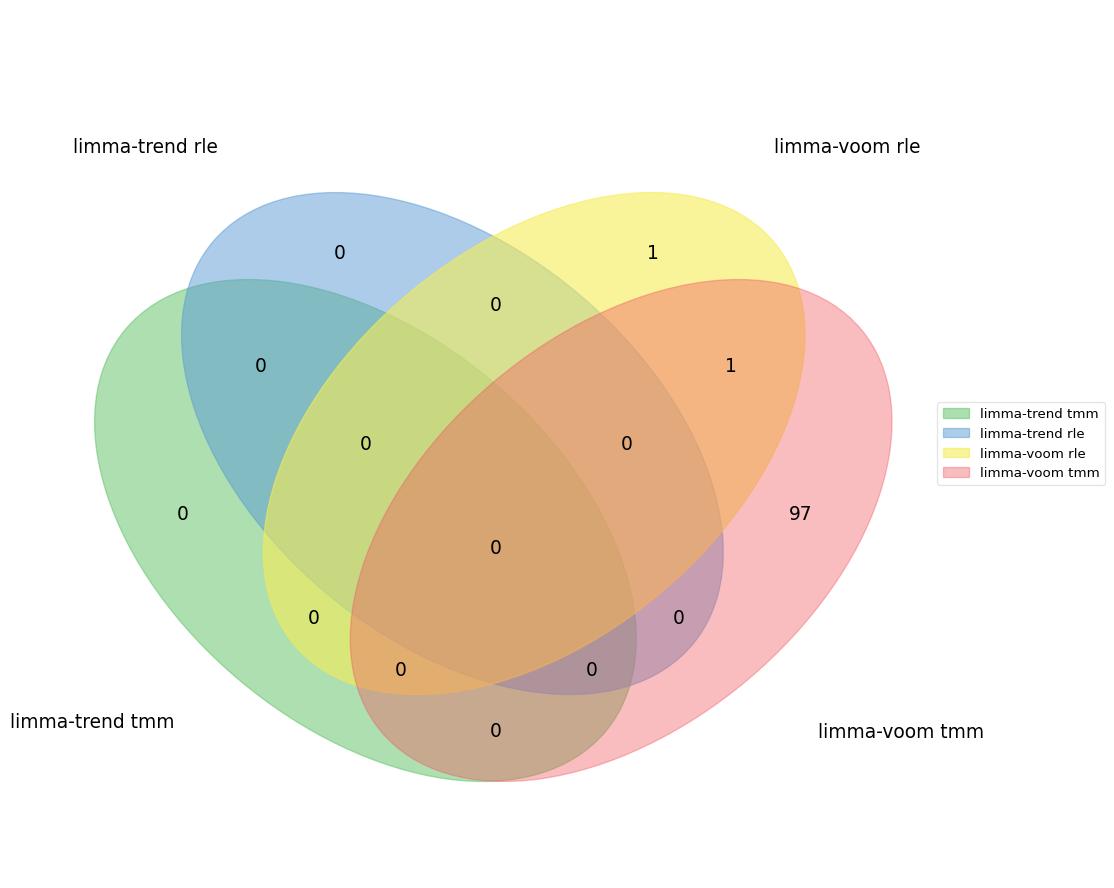

In [146]:
limma_degs = {'trend_tmm': trend_tmm, 'trend_rle': trend_rle, 'voom_rle': voom_rle, 'voom_tmm': voom_tmm}
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in limma_degs.items()});

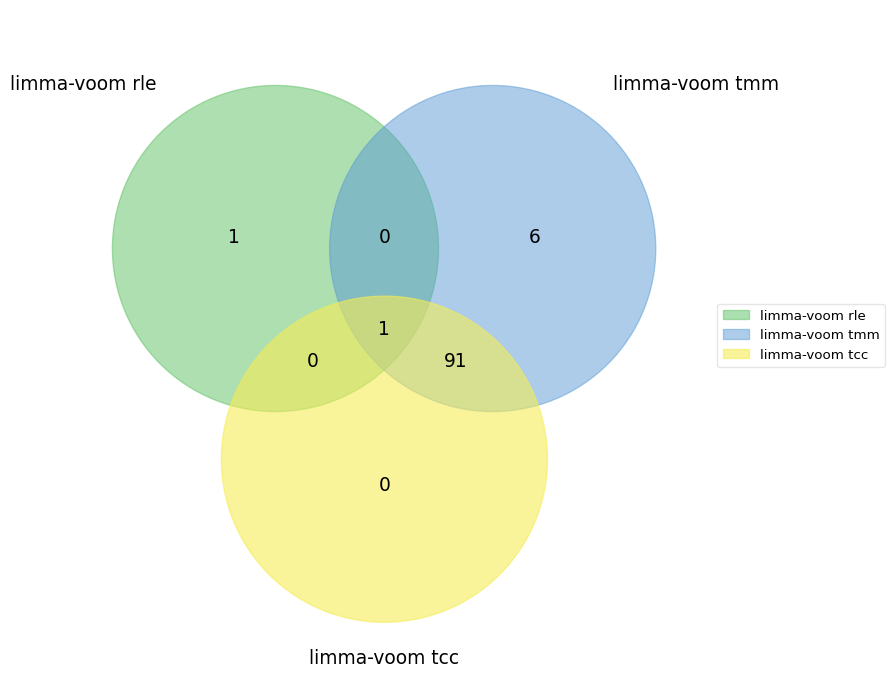

In [147]:
limma_degs = {'voom_rle': voom_rle, 'voom_tmm': voom_tmm, 'voom_tcc': voom_tcc}
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in limma_degs.items()});

When using TCC with TMM/voom we got one gene more and two less.

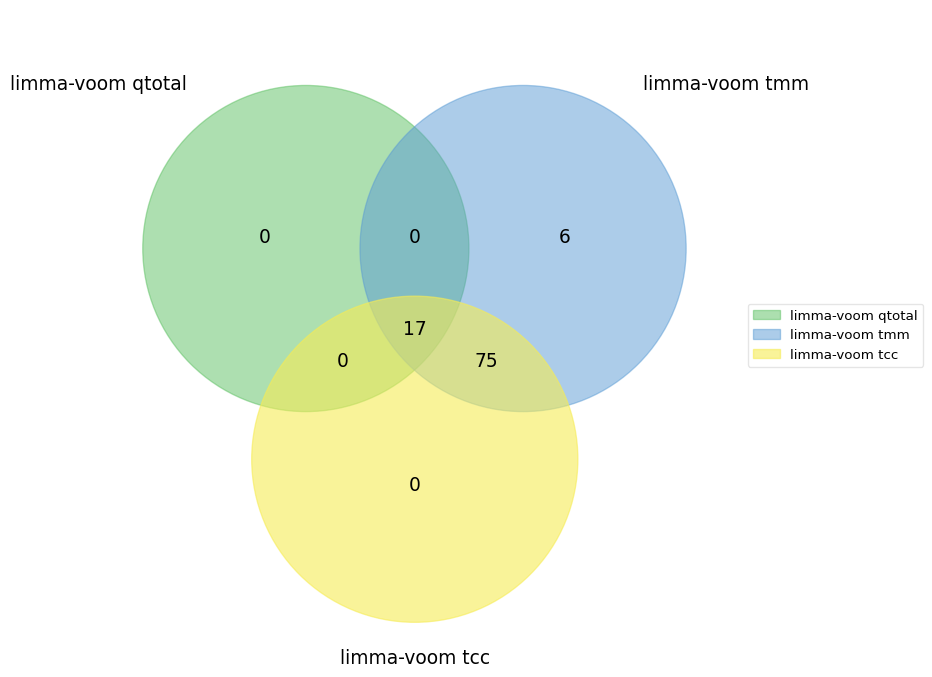

In [148]:
limma_degs = {'voom_qtotal': voom_qtotal, 'voom_tmm': voom_tmm, 'voom_tcc': voom_tcc}
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in limma_degs.items()});

In [149]:
degs_qtotal = with_gene_data(voom_qtotal)
degs_tcc = with_gene_data(voom_tcc)
degs_tmm = with_gene_data(voom_tmm)
degs_rle = with_gene_data(voom_rle)

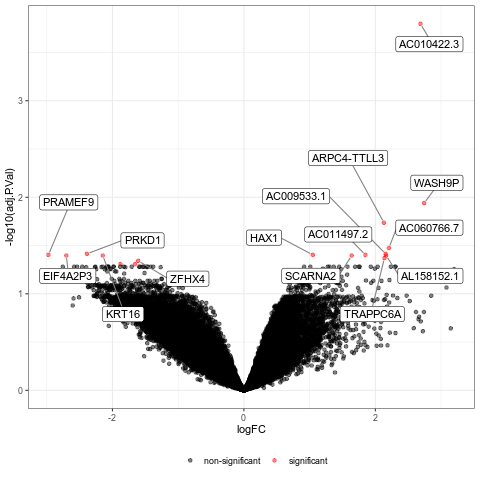

In [150]:
%%R -i degs_qtotal
volcano_plot(degs_qtotal, significant_only=F, transparency=0.5)

Finally something different... But does it make sense? (according to their simulations it's much better normalization method..)

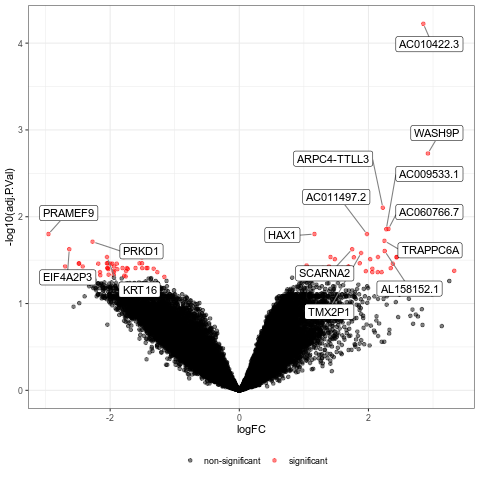

In [151]:
%%R -i degs_tcc
volcano_plot(degs_tcc, significant_only=F, transparency=0.5)

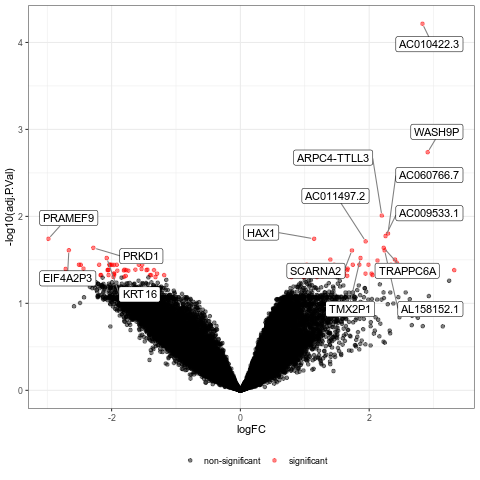

In [152]:
%%R -i degs_tmm
volcano_plot(degs_tmm, significant_only=F, transparency=0.5)

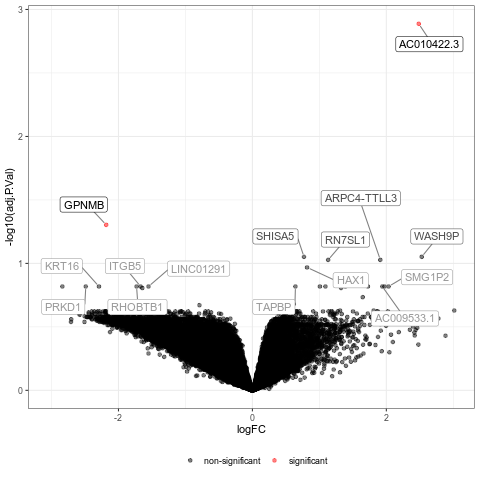

In [153]:
%%R -i degs_rle
volcano_plot(degs_rle, significant_only=F, transparency=0.5)

AC010422.3 is NMD variant of MAN2B1 (Mannosidase Alpha Class 2B Member 1)

> This gene encodes an enzyme that hydrolyzes terminal, non-reducing alpha-D-mannose residues in alpha-D-mannosides. Its activity is necessary for the catabolism of N-linked carbohydrates released during glycoprotein turnover and it is member of family 38 of glycosyl hydrolases [RefSeq]

Related to alpha-Mannosidosis, a lysosomal storage diseases. Likely a false positive, but who knows?

**Just occurred to be when reading the latest PubMed alert on TB Meningitis**, with a study on Lipoarabinomannan as a diagnostic test for TBM:

Unrelated Uniprot entry which explains relation to LM and LAM:
> P9WMZ3
> - GDP-mannose-dependent alpha-(1-6)-phosphatidylinositol monomannoside mannosyltransferase
> Involved in the biosynthesis of phosphatidyl-myo-inositol mannosides (PIM) which are early precursors in the biosynthesis of lipomannans (LM) and lipoarabinomannans (LAM) (PubMed:19395496). Catalyzes the addition of a mannosyl residue from GDP-D-mannose (GDP-Man) to the position 6 of a phosphatidyl-myo-inositol bearing an alpha-1,2-linked mannose residue (PIM1) to generate phosphatidyl-myo-inositol bearing alpha-1,2- and alpha-1,6-linked mannose residues (Ac1PIM2) (PubMed:19395496). 

So there is some thin, indirect link between AC010422.3 and TBM... Is it possible that the RNA that we observe is not an NMD variant of a human gene but a bacterial one?
Unlikely, blasting returns only mammals; I blasted using both cDNA and protein sequences.

[Ensembl](http://www.ensembl.org/Homo_sapiens/Transcript/Summary?db=core;g=ENSG00000269242;r=19:12643831-12648397;t=ENST00000597692), [Uniprot](https://www.uniprot.org/uniprot/M0QZ24)

LM blocks immune system of human macrophages (https://www.pnas.org/content/108/42/17408, TNF biosynthesis: MAPK-activated protein kinase 2 (MK2) and microRNA miR-125b). Anyway, time to move on.

In [154]:
degs_tmm.query('gene_name == "MAN2B1"')

logFC  AveExpr         t   P.Value  adj.P.Val         B  \
ENSG00000104774  0.478928  6.75465  1.625154  0.109188   0.308639 -5.131781   

                gene_name         biotype contig strand  
ENSG00000104774    MAN2B1  protein_coding     19      -

An even wilder idea: could TB reprogram human cells to produce a protein which is useful for its wall assembly?

Well the reprogramming is not a stupid idea per-se - [there  was an offer of PhD on UCL](https://www.findaphd.com/phds/project/reprogramming-of-human-host-cells-by-mycobacteria-a-cell-biology-approach/?p37576). A study from 2008 looked at the cross talk but used microarays so was rather unable to detect this transcript https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2151136/

- A good review from 2005: https://academic.oup.com/femsre/article/29/5/1041/546335 but no mention of cell transformation, other than the mycobacterium can traffic its proteins to the cytosol of the host:
> If the virulence of M. tuberculosis is dependent on the activity of mycobacterial phospho-proteins, **secretion of these proteins into the phagosome, and possibly through the phagosomal membrane into the host cell cytoplasm, is likely**. Secretion of bacterial protein into the host cell is critical for the intracellular survival of pathogens such as Salmonella and Yersinia[78]. The recent identification of a specified secretion system in mycobacteria [79, 80] raises the possibility of active transport of mycobacterial proteins into the host cell. Significantly, the culture medium of M. tuberculosis shows the presence of a protein tyrosine phosphatase [81] and a protein kinase [82], indicating an active secretion of these proteins

Terminology alert: if this was a thing we would probably refer to it as bactofection as bacterial transfection is already used for an unrelated procedure. 

In [155]:
from helpers.r import r_function

add_p_value_for_filtered_subset = partial(r_function, 'add_p_value_for_filtered_subset')
add_p_value_for_weighted_hypothesis = partial(r_function, 'add_p_value_for_weighted_hypothesis')
    
def apply_to_degs(dicts_with_degs, func, **kwargs):
        return {
            k: func(v, **kwargs)
            for k, v in dicts_with_degs.items()
        }
    
filter_degs = partial(apply_to_degs, func=add_p_value_for_filtered_subset)
weight_degs = partial(apply_to_degs, func=add_p_value_for_weighted_hypothesis)

In [156]:
limma_filtered_degs = filter_degs(limma_degs)

In [157]:
tb_cm_degs_filtered = with_gene_data(limma_filtered_degs['voom_tmm'])
tb_cm_degs_filtered.head(10)

logFC   AveExpr         t   P.Value  adj.P.Val  ...  \
ENSG00000100226  1.029827  7.260463  4.429861  0.000039   0.033039  ...   
ENSG00000164054  1.112747  7.195749  4.249379  0.000073   0.033039  ...   
ENSG00000005339  0.733323  8.951539  3.226780  0.001999   0.038180  ...   
ENSG00000055332  1.069789  8.454140  3.289720  0.001671   0.038180  ...   
ENSG00000075568  0.685300  7.380068  3.229124  0.001985   0.038180  ...   
ENSG00000102096  0.995264  7.206481  3.528854  0.000791   0.038180  ...   
ENSG00000105939  0.879815  8.203956  3.270173  0.001755   0.038180  ...   
ENSG00000107099  0.903048  9.321746  3.432383  0.001069   0.038180  ...   
ENSG00000107201  1.216507  7.305200  3.281786  0.001790   0.038180  ...   
ENSG00000107290  0.842533  8.871874  3.299155  0.001608   0.038180  ...   

                 unfiltered.adj.P.Val  gene_name         biotype contig strand  
ENSG00000100226              0.035972     GTPBP1  protein_coding     22      +  
ENSG00000164054              0.041450     SHISA5  protein_coding      3      -  
ENSG00000005339              0.088418     CREBBP  protein_coding     16      -  
ENSG00000055332              0.085226    EIF2AK2  protein_coding      2      -  
ENSG00000075568              0.088319    TMEM131  protein_coding      2      -  
ENSG00000102096              0.077671       PIM2  protein_coding      X      -  
ENSG00000105939              0.085401    ZC3HAV1  protein_coding      7      -  
ENSG00000107099              0.082278      DOCK8  protein_coding      9      +  
ENSG00000107201              0.086053      DDX58  protein_coding      9      -  
ENSG00000107290              0.085226       SETX  protein_coding      9      -  

[10 rows x 11 columns]

In [158]:
tb_cm_degs_weighted = with_gene_data(add_p_value_for_weighted_hypothesis(limma_degs['voom_tmm']))
tb_cm_degs_weighted.head(10)

logFC   AveExpr         t       P.Value  adj.P.Val  ...  \
ENSG00000269242  2.827638  1.149172  7.011485  2.025798e-09   0.000167  ...   
ENSG00000279457  2.908448  0.292050  5.975723  1.212733e-07   0.015809  ...   
ENSG00000100226  1.029827  7.260463  4.429861  3.894655e-05   0.026312  ...   
ENSG00000185507  1.372638  6.829419  4.337698  5.379385e-05   0.027257  ...   
ENSG00000164054  1.112747  7.195749  4.249379  7.309493e-05   0.029798  ...   
ENSG00000278249  1.732098  3.118477  4.813455  9.849573e-06   0.029798  ...   
ENSG00000013364  0.881037  7.037342  3.600332  6.313521e-04   0.039038  ...   
ENSG00000077238  1.093233  6.295783  3.965866  1.916372e-04   0.039038  ...   
ENSG00000091656 -1.536711  3.789822 -4.610522  2.050378e-05   0.039038  ...   
ENSG00000101294  0.770133  7.166021  3.595842  6.404217e-04   0.039038  ...   

                 unweighted.adj.P.Val   gene_name                 biotype  \
ENSG00000269242              0.000061  AC010422.3          protein_coding   
ENSG00000279457              0.001827      WASH9P  unprocessed_pseudogene   
ENSG00000100226              0.035972      GTPBP1          protein_coding   
ENSG00000185507              0.039880        IRF7          protein_coding   
ENSG00000164054              0.041450      SHISA5          protein_coding   
ENSG00000278249              0.024614     SCARNA2                  scaRNA   
ENSG00000013364              0.073171         MVP          protein_coding   
ENSG00000077238              0.054465        IL4R          protein_coding   
ENSG00000091656              0.032156       ZFHX4          protein_coding   
ENSG00000101294              0.073171        HM13          protein_coding   

                contig strand  
ENSG00000269242     19      -  
ENSG00000279457      1      -  
ENSG00000100226     22      +  
ENSG00000185507     11      -  
ENSG00000164054      3      -  
ENSG00000278249      1      +  
ENSG00000013364     16      +  
ENSG00000077238     16      +  
ENSG00000091656      8      +  
ENSG00000101294     20      +  

[10 rows x 11 columns]

In [159]:
tb_cm_degs = with_gene_data(voom_tmm)
tb_cm_degs.head(10)

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000269242  2.827638  1.149172  7.011485  2.025798e-09   0.000061   
ENSG00000279457  2.908448  0.292050  5.975723  1.212733e-07   0.001827   
ENSG00000250151  2.196181  1.269911  5.434648  9.734822e-07   0.009776   
ENSG00000267745  2.291493  1.390648  5.231746  2.094772e-06   0.015778   
ENSG00000111788  2.254506  0.840659  5.154858  2.793695e-06   0.016834   
ENSG00000143575  1.144471  4.599025  5.076448  3.741515e-06   0.018110   
ENSG00000204505 -2.980992  0.491419 -5.044807  4.207768e-06   0.018110   
ENSG00000269374  1.945067  0.171853  4.990494  5.144424e-06   0.019374   
ENSG00000007255  2.225671 -0.017702  4.886008  7.555775e-06   0.023004   
ENSG00000184304 -2.283459  0.459673 -4.883145  7.635454e-06   0.023004   

                         B    gene_name                 biotype contig strand  
ENSG00000269242  11.021053   AC010422.3          protein_coding     19      -  
ENSG00000279457   7.155963       WASH9P  unprocessed_pseudogene      1      -  
ENSG00000250151   5.391370  ARPC4-TTLL3          protein_coding      3      +  
ENSG00000267745   4.664499   AC060766.7    processed_transcript     17      -  
ENSG00000111788   4.302809   AC009533.1  unprocessed_pseudogene     12      +  
ENSG00000143575   4.222494         HAX1          protein_coding      1      +  
ENSG00000204505   3.816541      PRAMEF9          protein_coding      1      +  
ENSG00000269374   3.898891   AC011497.2    processed_pseudogene     19      -  
ENSG00000007255   3.246110     TRAPPC6A          protein_coding     19      -  
ENSG00000184304   3.287640        PRKD1          protein_coding     14      -

Caveat: independent filtering may be done with respect to analyzed groups or entire experiment. Which one is better?

In [160]:
%%R -o voom_tmm_filtered_non_agressive
voom_tmm_filtered_non_agressive = add_p_value_for_filtered_subset(voom_tmm, use_deseq2_method=T)

In [161]:
tb_cm_degs_filtered_non_agressive = with_gene_data(voom_tmm_filtered_non_agressive)

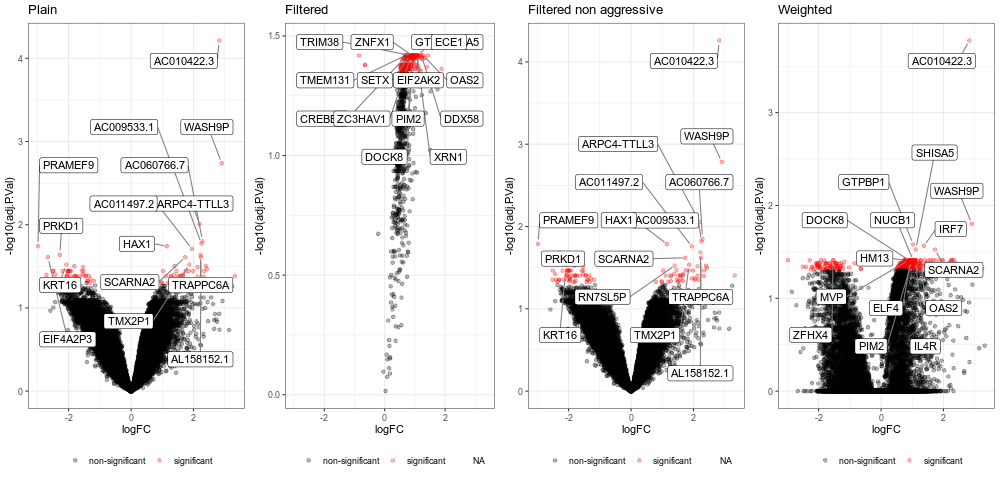

In [162]:
%%R -i tb_cm_degs_filtered -i tb_cm_degs_weighted -i tb_cm_degs -w 1000 -i tb_cm_degs_filtered_non_agressive

gridExtra::grid.arrange(
    volcano_plot(tb_cm_degs, significant_only=F, transparency=0.3) + ggtitle('Plain'),
    volcano_plot(tb_cm_degs_filtered, significant_only=F, transparency=0.3) + ggtitle('Filtered'),
    volcano_plot(tb_cm_degs_filtered_non_agressive, significant_only=F, transparency=0.3) + ggtitle('Filtered non aggressive'),
    volcano_plot(tb_cm_degs_weighted, significant_only=F, transparency=0.3) + ggtitle('Weighted'),
    ncol=4
)

> More realistic nonspecific filters can also detrimentally affect the conditional distribution of the test statistic. The limma t-statistic (Embedded Image) is based on an empirical Bayes approach which models the gene-level error variances Embedded Image with a scaled inverse χ2 distribution. For many microarray datasets, this distribution provides a good fit (4). In ref. 7, an overall variance filter is combined with the limma Embedded Image. Because the within-class variance estimator (Embedded Image) and the overall variance are correlated, filtering on overall variance will deplete the set of genes with low Embedded Image (Fig. 2B). A scaled inverse χ2 will then no longer provide a good fit to the data passing the filter, causing the limma algorithm to produce a posterior degrees-of-freedom estimate of ∞. This has two consequences: (i) gene-level variance estimates will be ignored, leading to an unintended analysis based on fold change only; and (ii) the p-values will be overly optimistic (Fig. 2C). See SI Text for details.

> Moderated t-statistics like the limma T^ are also often used to avoid discoveries with small effect sizes. Further, the null distribution for Embedded Image is typically more concentrated than that of the standard t-statistic. In many cases, this concentration also produces power gains—gains which may exceed those obtained by the combination of variance filtering and the standard t-statistic. Can even greater power gains be obtained by combining filtering and moderation? Perhaps, but Fig. 2C shows that such an approach has the potential to inflate the false positive rate when the sample size is small. Thus, we do not recommend combining limma with a filtering procedure which interferes with its distributional assumptions. We are therefore left with two options: variance filtering combined with the standard T, or an unfiltered Embedded Image. Each option addresses the issue of small effect sizes, and each can improve power. Which one provides the best improvement is data dependent, and we provide further examples and discussion in SI Text. (https://www.pnas.org/content/107/21/9546)

There is an interesting correspondence between creators of limma and DESeq2 (including genefilter) published on bioconductor. Picking some fragments in favour of using genefilter for limma:

> In reality, filtering low intensity probes (not low variance probes) is usually of benefit to limma, and we do this routinely for nearly all analyses in my lab. This is for a number of reasons.
 
> First there is the generic (not specific to limma) reason that probes that are not detecting real signal to any worthwhile degree for any sample cannot be detecting DE to any worthwhile degree. Therefore there is a positive correlation between mean log intensity and true DE.

> Second there is the limma-specific reason that probes that are not detecting signal above background levels in any sample trend to have atypical variances, both in absolute size and in terms of mean- variance relationship, compared to probes that are responding to genuine biological signal. In other words, non-expressed or dead probes have variances that cannot be considered to be sampled from the same population as variances for probes from regular expressed probes. It is desirable to get rid of these atypical probes so that limma can concentrate on the behaviour of probes of genuine interest. Filtering by mean log-intensity does not cause any problems for the limma probabilistic model. Indeed it generally improves concordance with the empirical Bayes assumptions.

(https://support.bioconductor.org/p/53061/)

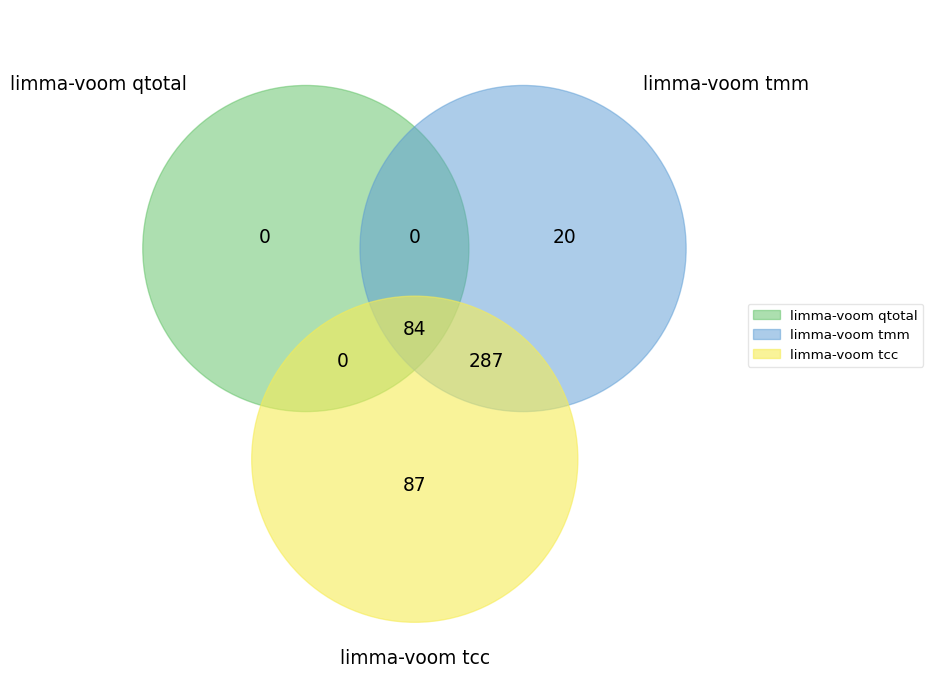

In [163]:
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in limma_filtered_degs.items()});

There is a high agreement for significantly changed gene sets:

In [164]:
%%R -o gs_trend_tmm -o gs_trend_rle -o gs_voom_rle -o gs_voom_tmm
gs_trend_tmm = calc_camera('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers)
gs_trend_rle = calc_camera('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers)
gs_voom_rle = calc_camera('Tuberculosis', 'Cryptococcal', rle_normalized, by_condition_no_outliers, voom=T, quality_weights=T)
gs_voom_tmm = calc_camera('Tuberculosis', 'Cryptococcal', tmm_normalized, by_condition_no_outliers, voom=T, quality_weights=T)

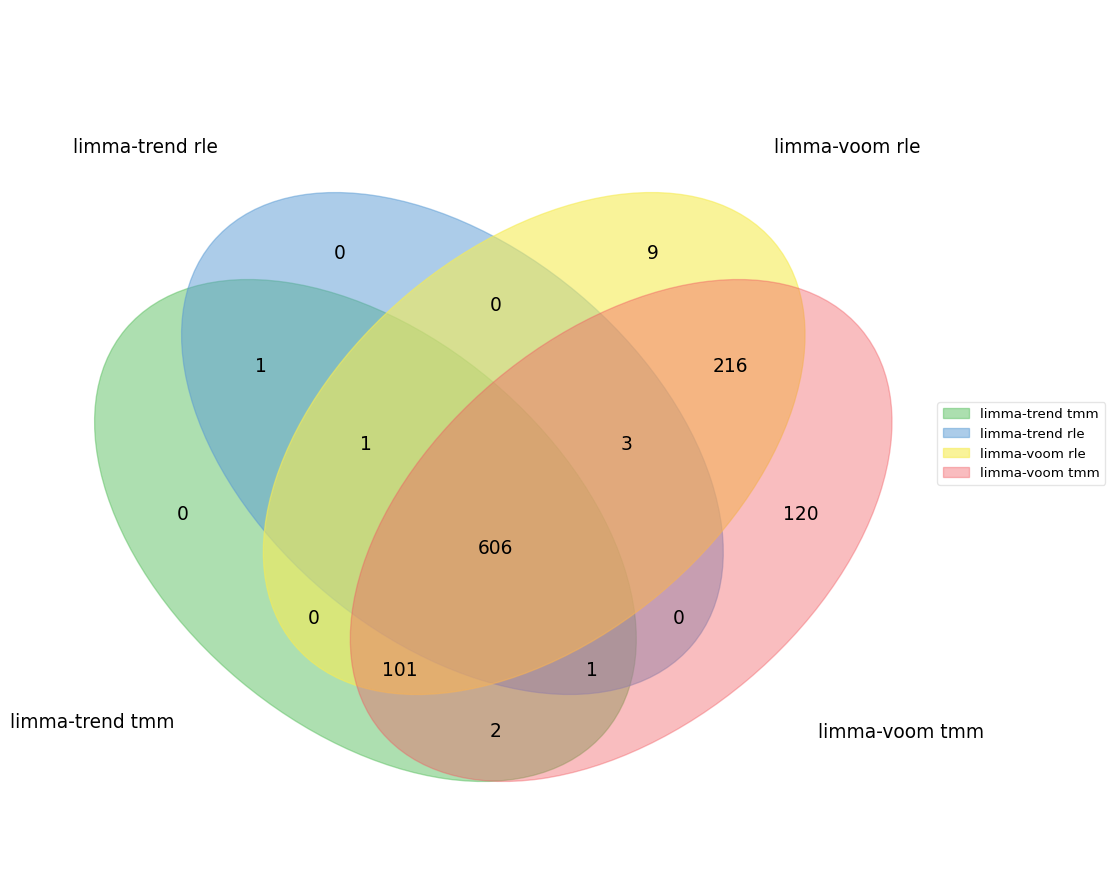

In [165]:
limma_gene_sets = {'trend_tmm': gs_trend_tmm, 'trend_rle': gs_trend_rle, 'voom_rle': gs_voom_rle, 'voom_tmm': gs_voom_tmm}
limma_venn({k: list(v[v.FDR < 0.05].index) for k, v in limma_gene_sets.items()});

In [166]:
tb_cm_gene_sets = gs_voom_tmm
tb_cm_gene_sets.head(10)

NGenes Direction  \
Signaling by the B Cell Receptor (BCR)               161.0        Up   
Fc epsilon receptor (FCERI) signaling                186.0        Up   
Processing of Capped Intron-Containing Pre-mRNA      238.0        Up   
mRNA Splicing - Major Pathway                        180.0        Up   
FCERI mediated NF-kB activation                      134.0        Up   
mRNA Splicing                                        188.0        Up   
FCERI mediated Ca+2 mobilization                      85.0        Up   
Influenza Infection                                  153.0        Up   
SRP-dependent cotranslational protein targeting...   112.0        Up   
Ub-specific processing proteases                     175.0        Up   

                                                          PValue           FDR  
Signaling by the B Cell Receptor (BCR)              4.546899e-23  7.720634e-20  
Fc epsilon receptor (FCERI) signaling               6.064331e-22  4.194180e-19  
Processing of Capped Intron-Containing Pre-mRNA     7.410211e-22  4.194180e-19  
mRNA Splicing - Major Pathway                       1.749342e-21  6.767731e-19  
FCERI mediated NF-kB activation                     1.992854e-21  6.767731e-19  
mRNA Splicing                                       8.491324e-21  2.403045e-18  
FCERI mediated Ca+2 mobilization                    2.024291e-18  4.910352e-16  
Influenza Infection                                 4.255750e-18  9.032830e-16  
SRP-dependent cotranslational protein targeting...  5.016281e-18  9.464049e-16  
Ub-specific processing proteases                    8.797535e-18  1.483776e-15

### Definite Tuberculosis vs Cryptococcal

In [167]:
%%R
stopifnot(
    length(by_condition_and_tb_subset_no_outliers) == length(by_condition_no_outliers)
)

In [168]:
%%R
tmm_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='TMM')
rle_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='RLE')
eee_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='TMM', test_method='voom', iterations=3)
qtotal_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='qtotal')

[1] "Retaining: 62.63%"
[1] "Retaining: 62.63%"
[1] "Retaining: 62.63%"
TCC::INFO: Calculating normalization factors using DEGES
TCC::INFO: (iDEGES pipeline : tmm - [ voom - tmm ] X 3 )
TCC::INFO: Done.
[1] "Retaining: 62.63%"


notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.


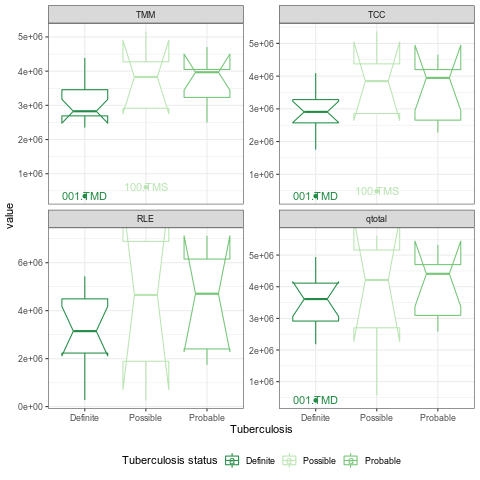

In [169]:
%%R
df = reshape::melt(data.frame(
    TMM=size_factors(tmm_normalized_tb_subsets),
    TCC=size_factors(eee_normalized_tb_subsets),
    RLE=size_factors(rle_normalized_tb_subsets),
    qtotal=size_factors(qtotal_normalized_tb_subsets),
    Meningitis=by_condition_and_tb_subset_no_outliers,
    Tuberculosis=sub(' tuberculosis', '', by_condition_and_tb_subset_no_outliers),
    patient=as.character(names(by_condition_no_outliers))
), id=c('Meningitis', 'patient', 'Tuberculosis'))
(
    ggplot(df[grepl('tuberculosis',df$Meningitis),], aes(y=value, x=Tuberculosis, color=Tuberculosis))
    + facet_wrap('variable', scales='free_y')
    + geom_boxplot(notch=T)
    + nice_theme
    + geom_text(aes(
        label=label_outliers(
            label=patient,
            value=value,
            group=interaction(variable, Meningitis)
        )
    ))
    + color_tuberculosis
)

In [170]:
%%R
# ddd_normalized_tb_subsets = preprocess_limma(raw_counts_matrix_no_outliers, by_condition_and_tb_subset_no_outliers, 'Definite tuberculosis', method='deseq2', , test_method='deseq2', iterations=3)

NULL


In [171]:
Path(rna_tmm_normalized_counts_path).parent.mkdir(exist_ok=True)

In [172]:
%%R -i rna_tmm_normalized_counts_path -i rna_rle_normalized_counts_path
import::here(extract_counts, .from='helpers/differential_expression.R')

write.csv(
    edgeR::cpm(tmm_normalized_tb_subsets, log=T),
    file=rna_tmm_normalized_counts_path
)
write.csv(
    edgeR::cpm(rle_normalized_tb_subsets, log=T),
    file=rna_rle_normalized_counts_path
)

In [173]:
%%R -o definite_tb_cm_voom_tmm -o definite_tb_cm_voom_rle -o definite_tb_cm_trend_tmm -o definite_tb_cm_trend_rle -o definite_tb_cm_voom_eee -o definite_tb_cm_voom_qtotal
definite_tb_cm_voom_tmm = calc_de('Definite tuberculosis', 'Cryptococcal', tmm_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)
definite_tb_cm_voom_rle = calc_de('Definite tuberculosis', 'Cryptococcal', rle_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)
definite_tb_cm_voom_eee = calc_de('Definite tuberculosis', 'Cryptococcal', eee_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)
definite_tb_cm_voom_qtotal = calc_de('Definite tuberculosis', 'Cryptococcal', qtotal_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)

definite_tb_cm_trend_tmm = calc_de('Definite tuberculosis', 'Cryptococcal', tmm_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers)
definite_tb_cm_trend_rle = calc_de('Definite tuberculosis', 'Cryptococcal', rle_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers)

# maybe also:
# definite_tb_cm_voom_ddd = calc_de('Definite tuberculosis', 'Cryptococcal', ddd_normalized_tb_subsets, by_condition_and_tb_subset_no_outliers, voom=T, quality_weights=T)
# ?

In [174]:
with_gene_data(definite_tb_cm_voom_eee).sort_values('adj.P.Val').head()

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000269242  2.816228  1.243756  6.013799  9.461491e-08   0.003451   
ENSG00000224789  3.395980 -1.116058  5.488784  7.340641e-07   0.013386   
ENSG00000270140  2.442870 -0.461484  4.988627  4.892521e-06   0.059477   
ENSG00000100226  1.055329  7.355047  4.606109  1.992304e-05   0.065814   
ENSG00000103257  1.388213  5.973513  4.733698  1.253557e-05   0.065814   

                        B   gene_name         biotype contig strand  
ENSG00000269242  7.042106  AC010422.3  protein_coding     19      -  
ENSG00000224789  3.895213  AC012363.1       antisense      2      -  
ENSG00000270140  2.989636  AC005520.3  sense_intronic     14      +  
ENSG00000100226  2.662542      GTPBP1  protein_coding     22      +  
ENSG00000103257  3.106547      SLC7A5  protein_coding     16      -

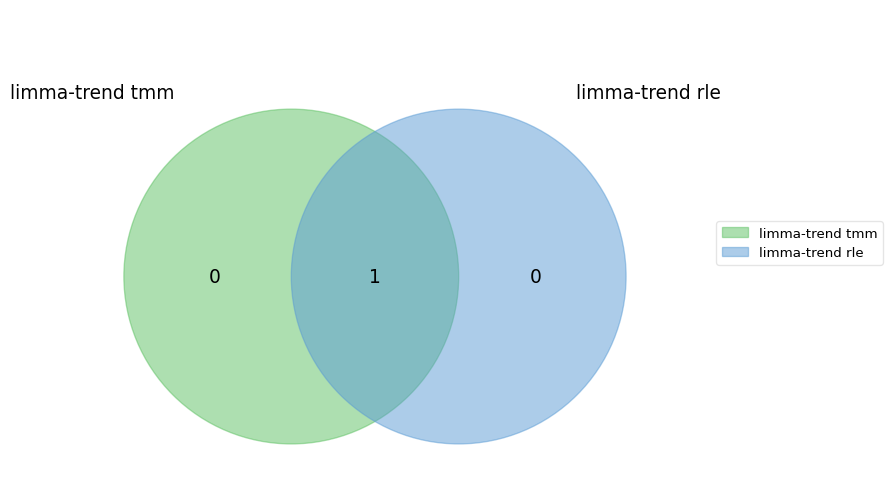

In [175]:
definite_tb_cm_trend_cmp = {
    'trend_tmm': definite_tb_cm_trend_tmm,
    'trend_rle': definite_tb_cm_trend_rle
}

definite_tb_cm_voom_cmp = {
    'voom_tmm': definite_tb_cm_voom_tmm,
    'voom_rle': definite_tb_cm_voom_rle,
    'voom_eee': definite_tb_cm_voom_eee,
    'voom_qtotal': definite_tb_cm_voom_qtotal
}

limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in definite_tb_cm_trend_cmp.items()});

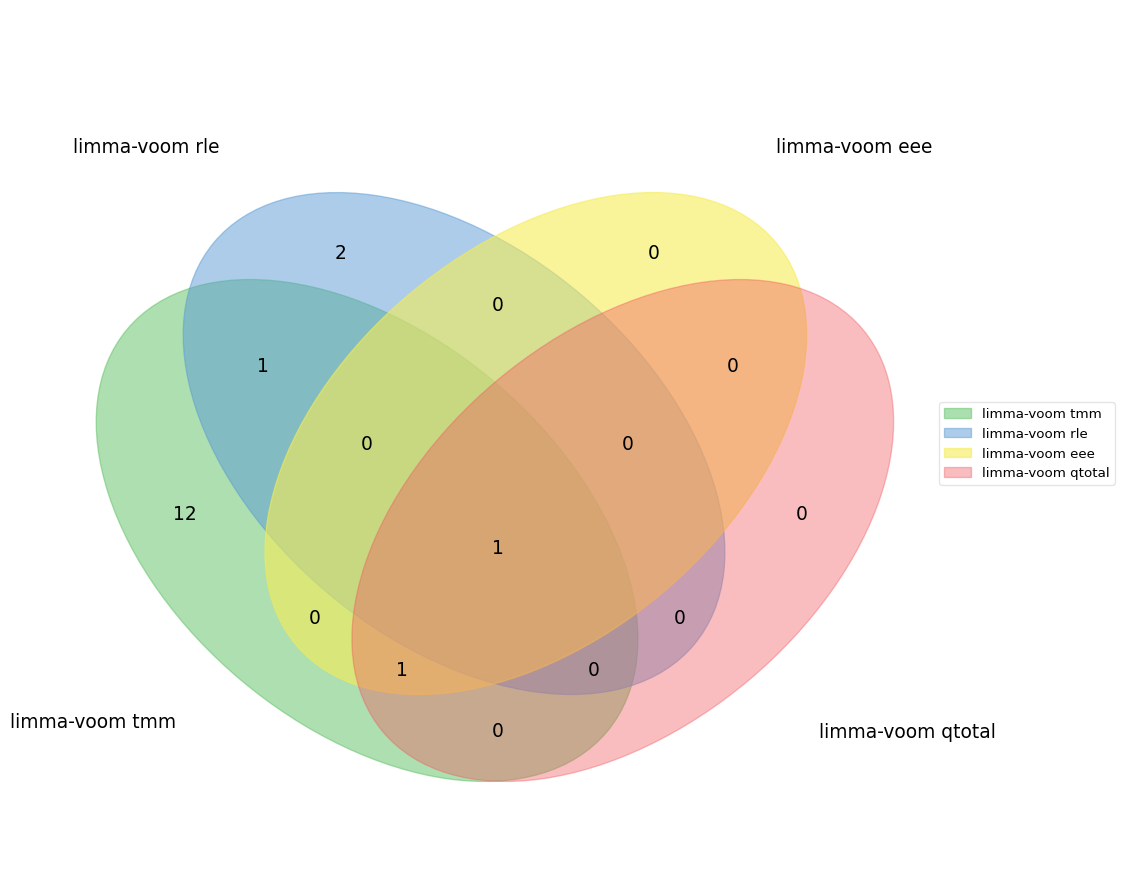

In [176]:
limma_venn({k: list(v[v['adj.P.Val'] < 0.05].index) for k, v in definite_tb_cm_voom_cmp.items()});

In [177]:
with_gene_data(definite_tb_cm_voom_cmp['voom_qtotal']).head(2)

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000269242  2.786742  0.996573  5.969896  1.052877e-07   0.003840   
ENSG00000224789  3.411041 -1.363240  5.522092  6.125118e-07   0.011169   

                        B   gene_name         biotype contig strand  
ENSG00000269242  6.838506  AC010422.3  protein_coding     19      -  
ENSG00000224789  3.864412  AC012363.1       antisense      2      -

In [178]:
with_gene_data(definite_tb_cm_voom_cmp['voom_rle']).head(2)

logFC   AveExpr         t       P.Value  adj.P.Val  \
ENSG00000164054  0.889999  7.185724  5.687146  4.061660e-07   0.007406   
ENSG00000269242  2.646894  1.139147  5.772662  2.932904e-07   0.007406   

                        B   gene_name         biotype contig strand  
ENSG00000164054  6.296126      SHISA5  protein_coding      3      -  
ENSG00000269242  5.110725  AC010422.3  protein_coding     19      -

AC010422.3 keeps popping up! Although it is missing in the DESeq2 results (likely filtered out in the very first step):

In [179]:
'ENSG00000269242' in set(reference_definite_tbm_cm_deg.index)

False

The other one (AC012363.1) is related to Inhibin beta B chain, annotated to be related to regulation of MAPK cascade.

**With independent filtering:**

TODO: independent filtering can be based on the mean for compared disease pairs only or on the mean for all samples. In the latter case it "borrows" the information on the importance of transcripts from other samples - which is usually ok; but again, we got a fairly specific setting - CSF - which makes it less obvious to explain.

In [180]:
%%R -o base_mean
samples = by_condition_and_tb_subset_no_outliers == 'Cryptococcal' | by_condition_and_tb_subset_no_outliers == 'Definite tuberculosis'
base_mean = rowMeans(tmm_normalized_tb_subsets$counts[,samples])[rownames(definite_tb_cm_voom_tmm)]

In [181]:
definite_tb_cm_cmp = {
    **definite_tb_cm_trend_cmp,
    **definite_tb_cm_voom_cmp
}

So this is blind/non-blind filtering decision...

In [182]:
# definite_tb_cm_limma_cmp_filtered = filter_degs(definite_tb_cm_cmp, expression_col=base_mean)

Or on the mean from the entire experiment:

In [183]:
definite_tb_cm_limma_cmp_filtered = filter_degs(definite_tb_cm_cmp)

In [184]:
%%R
require(ComplexUpset)

Loading required package: ComplexUpset


In [185]:
all_genes = list(set().union(*[result.index for result in definite_tb_cm_limma_cmp_filtered.values()]))

gene_matrix = DataFrame(dict(
    gene=all_genes,
    **{
        k: [gene in significant_in_k for gene in all_genes]
        for k, v in definite_tb_cm_limma_cmp_filtered.items()
        for significant_in_k in [set(v[v['adj.P.Val'] < 0.05].index)]
    }
))
gene_matrix_with_any = gene_matrix[gene_matrix.drop(columns='gene').any(axis=1)]

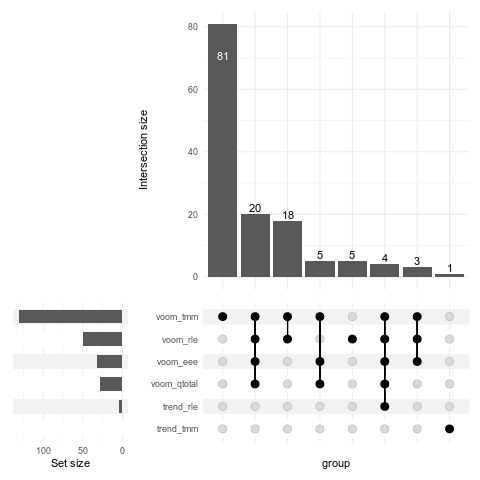

In [186]:
%%R -i gene_matrix_with_any
upset(gene_matrix_with_any, setdiff(colnames(gene_matrix_with_any), 'gene'))

In [187]:
filtered_significant = {
    k: list(v[v['adj.P.Val'] < 0.05].index)
    for k, v in definite_tb_cm_limma_cmp_filtered.items()
}

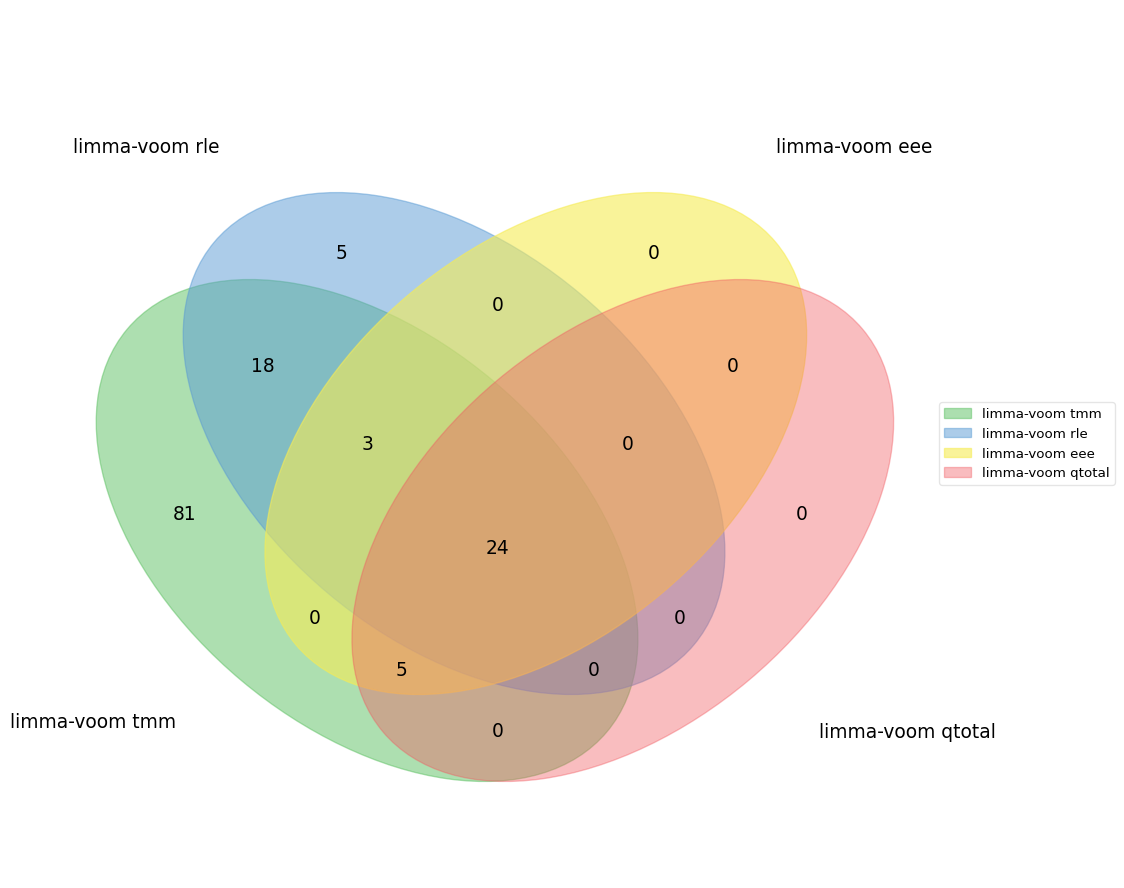

In [188]:
limma_venn(
    {
        k: v for k, v in filtered_significant.items()
        if k in ['voom_tmm', 'voom_rle', 'voom_qtotal', 'voom_eee']
    }
);

TMM and EEE seem to produce very comparable results for the top genes with TMM giving lower p-values.
Maybe using EEE would make sense, as it seem to be more conservative?

The more advanced normalization method, the fewer genes are significant; The 15 in the overlap may be worth checking out.

In [189]:
intersection = (
    set(filtered_significant['voom_qtotal'])
    &
    set(filtered_significant['voom_tmm'])
    &
    set(filtered_significant['voom_rle'])
)

In [190]:
show_table(with_gene_data(
    definite_tb_cm_limma_cmp_filtered['voom_qtotal'].loc[
        intersection
    ]
))

logFC   AveExpr         t   P.Value  adj.P.Val         B  \
ENSG00000164054  1.147751  7.043150  4.604045  0.000019  0.007758   2.686669   
ENSG00000100226  1.050689  7.107864  4.480894  0.000030  0.007758   2.282012   
ENSG00000130589  1.279371  7.369479  4.489909  0.000029  0.007758   2.302233   
ENSG00000185507  1.528794  6.676820  4.527315  0.000029  0.007758   2.335285   
ENSG00000117298  1.325047  7.092457  4.603994  0.000020  0.007758   2.677946   
ENSG00000184922  0.874216  8.242339  3.923266  0.000211  0.033720   0.416471   
ENSG00000173039  1.101608  7.145418  4.001008  0.000162  0.033720   0.722335   
ENSG00000128016  1.339082  8.595005  4.045008  0.000190  0.033720   0.555946   
ENSG00000231925  0.977877  9.171464  3.850453  0.000290  0.039622   0.096075   
ENSG00000148396  0.759870  7.629161  3.684340  0.000465  0.039622  -0.265557   
ENSG00000155363  1.117182  6.704352  3.706860  0.000433  0.039622  -0.125490   
ENSG00000185885  1.229688  6.769128  3.774082  0.000372  0.039622  -0.003202   
ENSG00000101294  0.786009  7.013422  3.741012  0.000387  0.039622  -0.064588   
ENSG00000142599  0.867350  8.144527  3.685825  0.000463  0.039622  -0.279872   
ENSG00000013364  0.867582  6.884743  3.629909  0.000555  0.041442  -0.395048   
ENSG00000178927  0.819405  7.071692  3.637404  0.000542  0.041442  -0.365871   
ENSG00000105329  0.968743  8.278026  3.626931  0.000584  0.041442  -0.511277   
ENSG00000129667  0.934966  6.727189  3.547886  0.000722  0.043894  -0.608313   
ENSG00000102034  0.880333  6.711961  3.553722  0.000709  0.043894  -0.599889   
ENSG00000197324  0.890049  6.971335  3.555738  0.000704  0.043894  -0.601979   
ENSG00000156860  0.813523  7.029535  3.431090  0.001043  0.047812  -0.971045   
ENSG00000166987  0.841221  7.023659  3.441821  0.001009  0.047812  -0.948582   
ENSG00000146112  0.849366  7.803297  3.474593  0.000910  0.047812  -0.904483   
ENSG00000170542  0.947776  7.189143  3.421125  0.001076  0.047812  -1.011168   

                 unfiltered.adj.P.Val gene_name         biotype contig strand  
ENSG00000164054  0.079134              SHISA5    protein_coding  3      -      
ENSG00000100226  0.079134              GTPBP1    protein_coding  22     +      
ENSG00000130589  0.079134              HELZ2     protein_coding  20     -      
ENSG00000185507  0.079134              IRF7      protein_coding  11     -      
ENSG00000117298  0.079134              ECE1      protein_coding  1      -      
ENSG00000184922  0.187903              FMNL1     protein_coding  17     +      
ENSG00000173039  0.164572              RELA      protein_coding  11     -      
ENSG00000128016  0.182690              ZFP36     protein_coding  19     +      
ENSG00000231925  0.211185              TAPBP     protein_coding  6      -      
ENSG00000148396  0.220763              SEC16A    protein_coding  9      -      
ENSG00000155363  0.220763              MOV10     protein_coding  1      +      
ENSG00000185885  0.220763              IFITM1    protein_coding  11     +      
ENSG00000101294  0.220763              HM13      protein_coding  20     +      
ENSG00000142599  0.220763              RERE      protein_coding  1      -      
ENSG00000013364  0.220763              MVP       protein_coding  16     +      
ENSG00000178927  0.220763              CYBC1     protein_coding  17     -      
ENSG00000105329  0.220763              TGFB1     protein_coding  19     -      
ENSG00000129667  0.232965              RHBDF2    protein_coding  17     -      
ENSG00000102034  0.232796              ELF4      protein_coding  X      -      
ENSG00000197324  0.232796              LRP10     protein_coding  14     +      
ENSG00000156860  0.258984              FBRS      protein_coding  16     +      
ENSG00000166987  0.258984              MBD6      protein_coding  12     +      
ENSG00000146112  0.247721              PPP1R18   protein_coding  6      -      
ENSG00000170542  0.262045              SERPINB9  protein_coding  6      -

In [191]:
deseq_intersection = reference_definite_tbm_cm_deg.loc[intersection]
sum(deseq_intersection.padj < 0.05)

13

In [192]:
list(deseq_intersection[deseq_intersection.padj < 0.05].ensembl_gene_name)

['SHISA5',
 'MOV10',
 'MVP',
 'GTPBP1',
 'IFITM1',
 'HM13',
 'RERE',
 'HELZ2',
 'IRF7',
 'ECE1',
 'RELA',
 'SERPINB9',
 'ZFP36']

### Comparing to DESeq2

- Limma-trend is more similar (than voom) to DESeq2 as both use gene-level mean-variance trend adjustment (whereas voom does it on observation-level).
- RLE normalization corresponds to the DESeq2 normalization

Thus, limma-trend with RLE is expected to agree with DESeq2 the most. Voom is expected to offer more power as it corrects the "noise" from the experimental setup better.

In [193]:
significant_deseq2 = reference_definite_tbm_cm_deg.query('padj < 0.05').index

In [194]:
reference_definite_tbm_cm_deg.head()

ensembl_gene_name  \
ensembl_id                          
ENSG00000100226            GTPBP1   
ENSG00000165997             ARL5B   
ENSG00000164691             TAGAP   
ENSG00000108771             DHX58   
ENSG00000128016             ZFP36   

                                                     description     baseMean  \
ensembl_id                                                                      
ENSG00000100226                           GTP binding protein 1    580.453924   
ENSG00000165997          ADP ribosylation factor like GTPase 5B    222.402492   
ENSG00000164691  T-cell activation RhoGTPase activating protein   1023.319959   
ENSG00000108771                            DExH-box helicase 58    125.298558   
ENSG00000128016                       ZFP36 ring finger protein   2070.881325   

                 log2FoldChange     lfcSE      stat        pvalue      padj  
ensembl_id                                                                   
ENSG00000100226        1.192190  0.219708  5.426243  5.755269e-08  0.000517  
ENSG00000165997        1.963330  0.393233  4.992789  5.951353e-07  0.001903  
ENSG00000164691        1.964425  0.394441  4.980279  6.349261e-07  0.001903  
ENSG00000108771        1.785542  0.367150  4.863249  1.154747e-06  0.002481  
ENSG00000128016        1.683438  0.348691  4.827880  1.379940e-06  0.002481

In [195]:
def get_limma_significant(data, threshold=0.05):
    return data[data['adj.P.Val'] < threshold]

def significant_ensembl(data, **kwargs):
    return get_limma_significant(data, **kwargs).index

#### Limma-trend

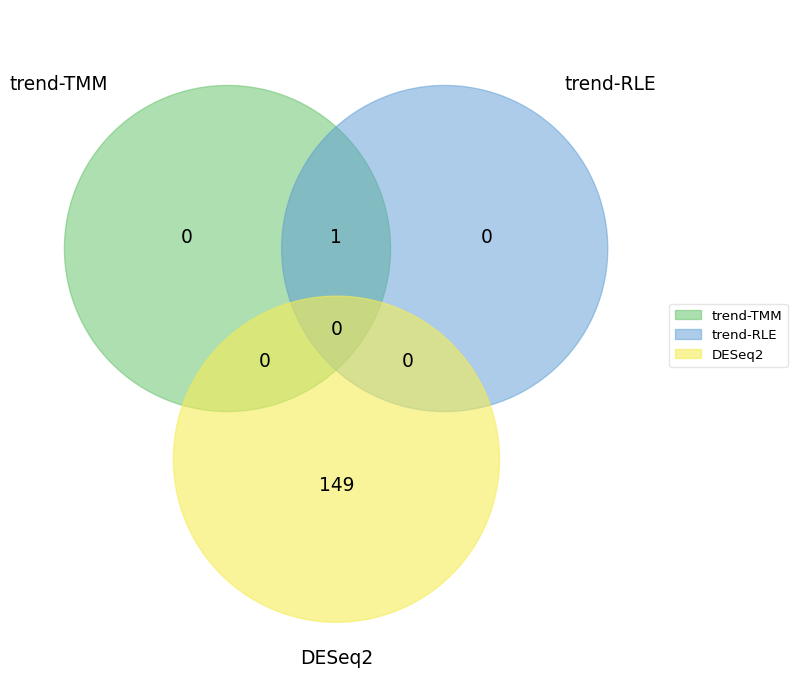

In [196]:
venn3({
    'trend-TMM': significant_ensembl(definite_tb_cm_trend_tmm),
    'trend-RLE': significant_ensembl(definite_tb_cm_trend_rle),
    'DESeq2': significant_deseq2
});

There is no intersection in significant genes and the limma-trend methods detect only of significant gene:

In [197]:
significant_definite_tb_cm_trend_tmm = significant_ensembl(definite_tb_cm_trend_tmm)
get_gene(significant_definite_tb_cm_trend_tmm[0]).gene_name

'WISP1'

Which was filtered out by independent filtering step in DESeq2:

In [198]:
reference_definite_tbm_cm_deg.loc[significant_definite_tb_cm_trend_tmm]

ensembl_gene_name  \
ENSG00000104415             WISP1   

                                                 description  baseMean  \
ENSG00000104415  WNT1 inducible signaling pathway protein 1   22.30457   

                 log2FoldChange     lfcSE      stat    pvalue  padj  
ENSG00000104415       -2.882794  0.623437 -4.624037  0.000004   NaN

Notably the top 15 genes of trend-RLE have a decent intersection with the top 15 of DESeq2:

In [199]:
head_deseq2 = reference_definite_tbm_cm_deg.head(15).index
intersection = set(head_deseq2) & set(definite_tb_cm_trend_rle.head(15).index)
[get_gene(g).gene_name for g in intersection]

['GTPBP1', 'DHX58', 'IRF7', 'ECE1']

For trend-TMM - less so:

In [200]:
assert set() == set(head_deseq2) & set(definite_tb_cm_trend_tmm.head(15).index)

#### Voom

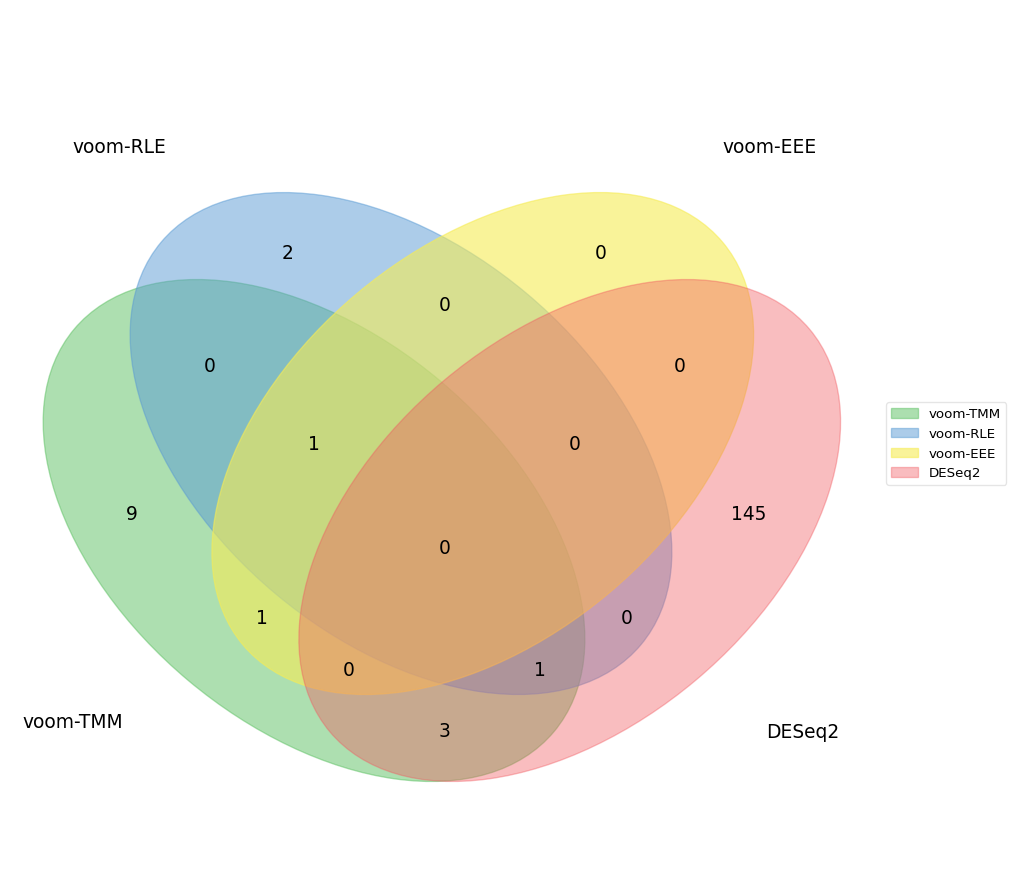

In [201]:
venn4({
    'voom-TMM': significant_ensembl(definite_tb_cm_voom_tmm),
    'voom-RLE': significant_ensembl(definite_tb_cm_voom_rle),
    'voom-EEE': significant_ensembl(definite_tb_cm_voom_eee),
    'DESeq2': significant_deseq2
});

### With independent filtering

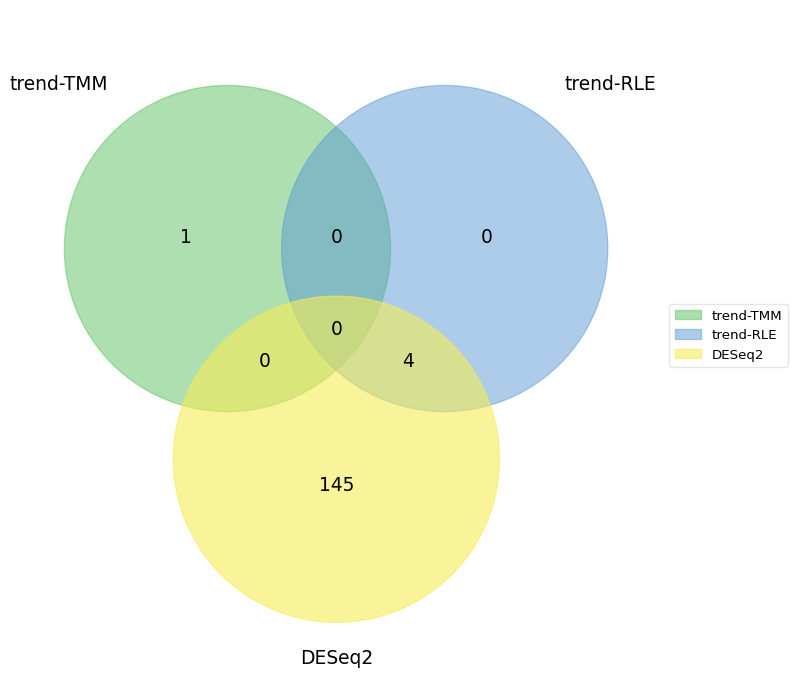

In [202]:
venn3({
    'trend-TMM': significant_ensembl(definite_tb_cm_limma_cmp_filtered['trend_tmm']),
    'trend-RLE': significant_ensembl(definite_tb_cm_limma_cmp_filtered['trend_rle']),
    'DESeq2': significant_deseq2
});

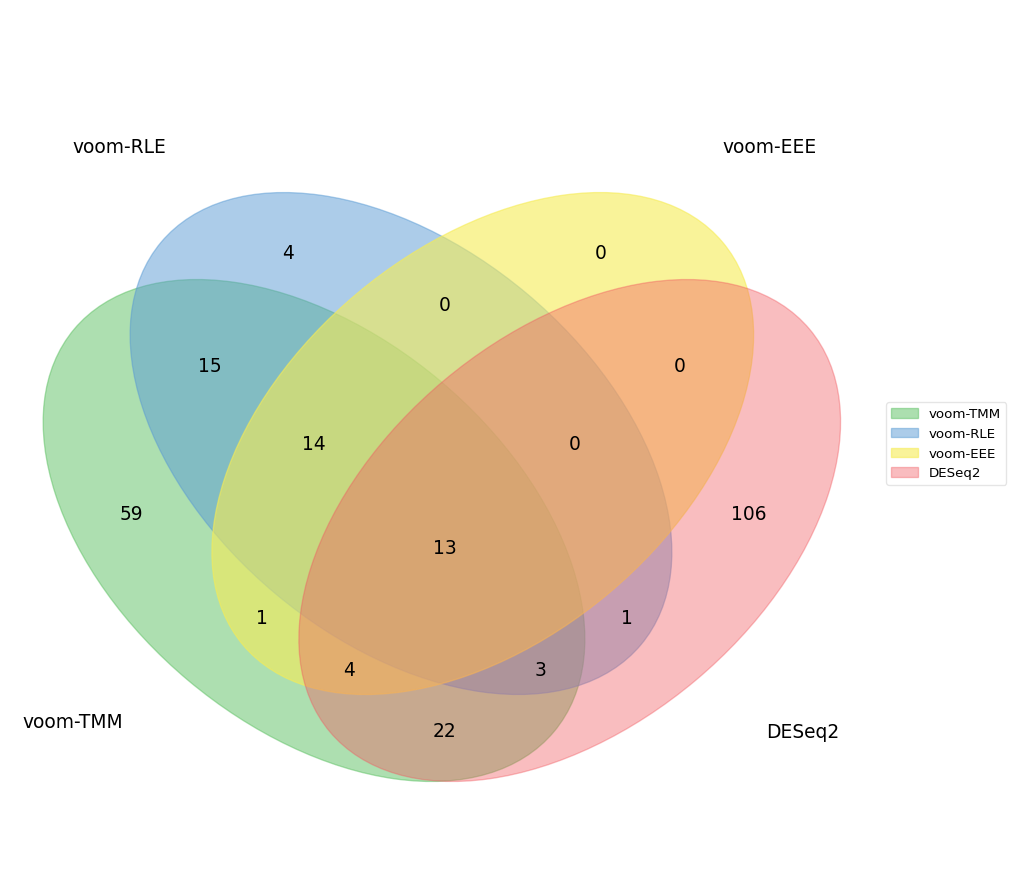

In [203]:
venn4({
    'voom-TMM': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_tmm']),
    'voom-RLE': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_rle']),
    'voom-EEE': significant_ensembl(definite_tb_cm_limma_cmp_filtered['voom_eee']),
    'DESeq2': significant_deseq2
});

While one might think that voom-TMM is more closely aligned with DESeq2 than voom-RLE (which would be counterintuitive as RLE is used in DESeq2), this is not actually the case:

Ratio of voom-TMM significant genes aligned with DESeq2:

In [204]:
(30 + 13) / (30 + 13 + 24 + 80)

0.2925170068027211

Ratio of voom-RLE significant genes aligned with DESeq2:

In [205]:
(1 + 13) / (1 + 13 + 24 + 3)

0.34146341463414637

### Finally, with weighted p-values:

In [206]:
definite_tb_cm_limma_cmp_weighted = weight_degs(definite_tb_cm_cmp)

We get slightly smaller overlap with DESeq2 and slightly fewer DE genes, but gain some interesting hits for genes which are not as highly expressed:

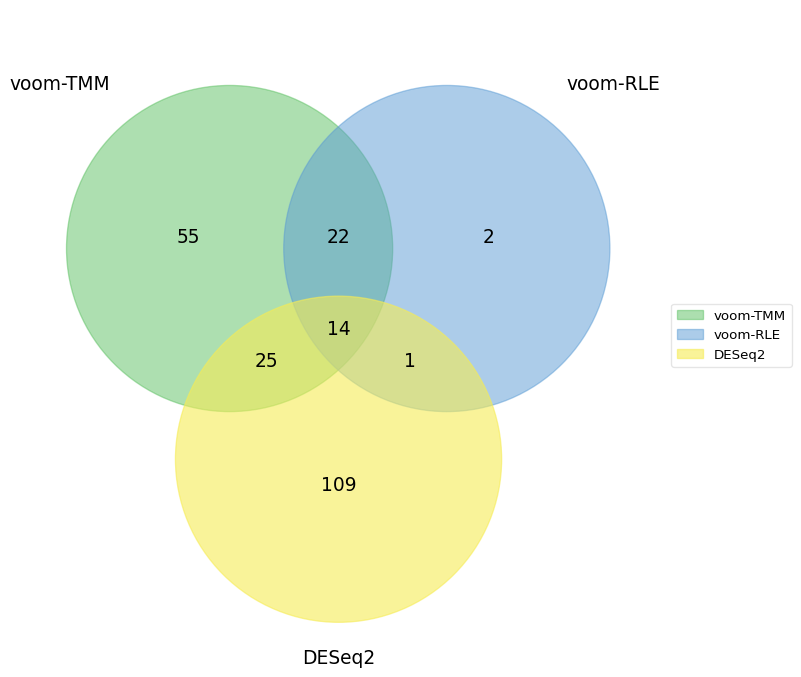

In [207]:
venn3({
    'voom-TMM': significant_ensembl(definite_tb_cm_limma_cmp_weighted['voom_tmm']),
    'voom-RLE': significant_ensembl(definite_tb_cm_limma_cmp_weighted['voom_rle']),
    'DESeq2': significant_deseq2
});

In [208]:
%%R
import::here(get_deseq_definite_tb_cm, .from='helpers/differential_expression.R')
import::here(de_comparison_pairplot, .from='plots/differential_expression.R')

In [209]:
%%R
conditions_for_deseq = factor(
    space_to_dot(by_condition_and_tb_subset_no_outliers)
)

dds_edger_prefiltered <- DESeq2::DESeqDataSetFromMatrix(
    countData = round(raw_counts_matrix[
        rownames(c_dge_tb_subsets_filtered$counts),
        names(by_condition_and_tb_subset_no_outliers)
    ]),
    colData = as.data.frame(conditions_for_deseq),
    design = ~ conditions_for_deseq
)
dds_edger_prefiltered <- DESeq2::DESeq(dds_edger_prefiltered)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 360 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [210]:
%%R -o deseq2_with_weighting
deseq2_with_weighting = get_deseq_definite_tb_cm(dds_edger_prefiltered, filterFun=IHW::ihw)

In [211]:
from helpers.de_comparisons import generate_comparison, voom_cols, deseq_cols

p_values = {
    **{
        f'{method_id}_weighted': data[list(voom_cols)].rename(voom_cols, axis=1)
        for method_id, data in definite_tb_cm_limma_cmp_weighted.items()
    },
    'deseq2_weighted': deseq2_with_weighting[deseq_cols],
}

In [212]:
weighted_comparisons = generate_comparison(p_values, ['deseq2_weighted', 'voom_tmm_weighted', 'voom_rle_weighted'], rename=ensembl_to_gene_name)

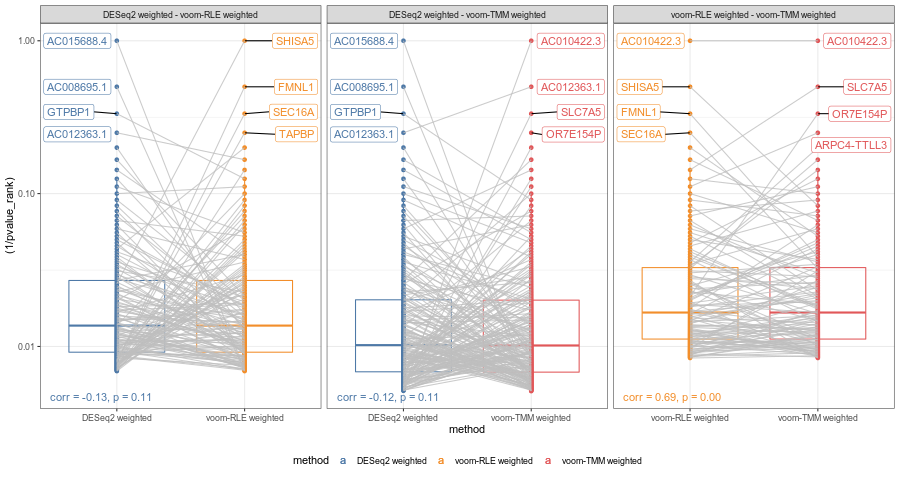

In [213]:
%%R -i weighted_comparisons -w 900

de_comparison_pairplot(weighted_comparisons)

### An attempt to use IHW for gene sets analysis

In [214]:
voom_de = definite_tb_cm_limma_cmp_weighted['voom_tmm']

In [215]:
%%R -o voom_de_gene_sets -i voom_de
voom_de_gene_sets = camera_with_statistic(voom_de, 't', reactome_new_symbol)

In [216]:
%%R -o voom_de_gene_sets_weighted
voom_de$weighted_stat <- voom_de$adj.P.Val * sign(voom_de$t)
voom_de_gene_sets_weighted = camera_with_statistic(voom_de, 'weighted_stat', reactome_new_symbol)

In [217]:
%%R -o voom_de_gene_sets_unweighted
voom_de$unweighted_stat <- voom_de$unweighted.adj.P.Val * sign(voom_de$t)
voom_de_gene_sets_unweighted = camera_with_statistic(voom_de, 'unweighted_stat', reactome_new_symbol)

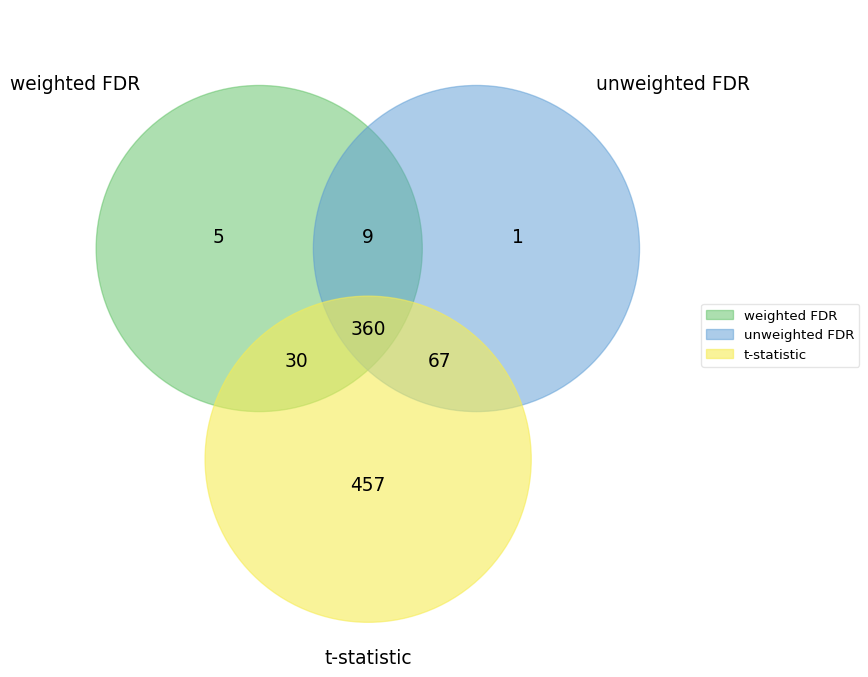

In [218]:
sig = lambda x: set(x[x.FDR < 0.05].index)
sets_comparison = {
    'weighted FDR': sig(voom_de_gene_sets_weighted),
    'unweighted FDR': sig(voom_de_gene_sets_unweighted),
    't-statistic': sig(voom_de_gene_sets)
}
venn3(sets_comparison);

In [219]:
sets_comparison['weighted FDR'] - sets_comparison['unweighted FDR'] - sets_comparison['t-statistic']

{'Formation of tubulin folding intermediates by CCT/TriC',
 'Mismatch repair (MMR) directed by MSH2:MSH6 (MutSalpha)',
 'Neurexins and neuroligins',
 'Recycling of eIF2:GDP',
 'Telomere Extension By Telomerase'}

In [220]:
sets_comparison['weighted FDR'] - sets_comparison['t-statistic']

{'Activation of ATR in response to replication stress',
 'Formation of tubulin folding intermediates by CCT/TriC',
 'Lipid particle organization',
 'Mismatch repair (MMR) directed by MSH2:MSH6 (MutSalpha)',
 'Molybdenum cofactor biosynthesis',
 'Neurexins and neuroligins',
 'PCNA-Dependent Long Patch Base Excision Repair',
 'Potassium Channels',
 'Purine salvage',
 'RNA Polymerase III Chain Elongation',
 'RNA Polymerase III Transcription Termination',
 'Recycling of eIF2:GDP',
 'Resolution of Abasic Sites (AP sites)',
 'Telomere Extension By Telomerase'}

In [221]:
comparison = concat([
    voom_de_gene_sets_unweighted.query('FDR < 0.05')[['FDR']].rank(method='first').assign(method='unweighted FDR'),
    voom_de_gene_sets.query('FDR < 0.05')[['FDR']].rank(method='first').assign(method='t-statistic')
]).rename_axis('pathway').reset_index()

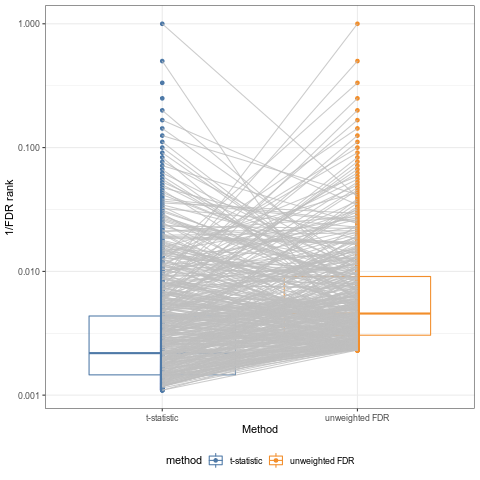

In [222]:
%%R -i comparison
(
    (
    ggplot(na.omit(comparison), aes(x=method, y=1/FDR, color=method))
        + geom_boxplot(alpha=0.2)
        + geom_point()
        + scale_y_log10()
        + geom_line(aes(group=pathway), color='grey', alpha=0.8)
        + nice_theme
        + scale_color_manual(values=ggthemes::tableau_color_pal('Tableau 10')(3))
        + xlab('Method')
        + ylab('1/FDR rank')
    )
)

This is very bad. I got a better idea: apply `genefilter()` on mean pathway expression level!

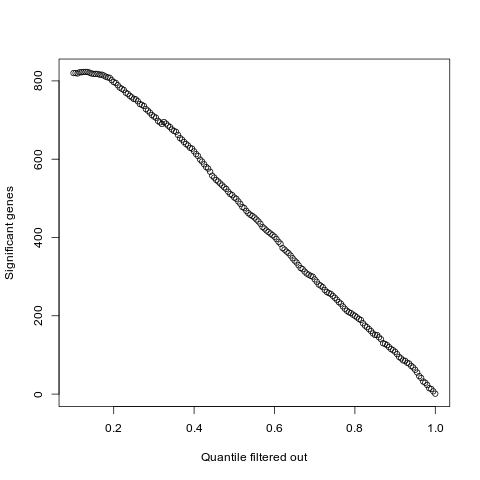

In [223]:
%%R
import::here(average_pathways_expression, .from='helpers/pathways.R')

voom_de_gene_sets$AveExpr = average_pathways_expression(
    tmm_normalized_tb_subsets, collection=reactome_new_symbol, id_type='symbol',
    pathways_subset=rownames(voom_de_gene_sets)
)

filter_by_mean_expression(voom_de_gene_sets, fdr_threshold=0.05, step=0.005, expression_col='AveExpr', pvalue_col='FDR', show_plot=T, use_deseq2_method=F)

It does increase power at $\theta \approx 0.1$ maybe?

In [224]:
voom_de_gene_sets

NGenes Direction  \
Neutrophil degranulation                             464.0        Up   
Interferon Signaling                                 197.0        Up   
Interferon alpha/beta signaling                       69.0        Up   
Interferon gamma signaling                            91.0        Up   
CLEC7A (Dectin-1) signaling                           98.0        Up   
...                                                    ...       ...   
Cation-coupled Chloride cotransporters                 7.0        Up   
Unwinding of DNA                                      12.0      Down   
Downstream signaling of activated FGFR1               30.0      Down   
Metabolism of steroid hormones                        33.0      Down   
Activation of PPARGC1A (PGC-1alpha) by phosphor...    10.0      Down   

                                                          PValue           FDR  
Neutrophil degranulation                            9.522604e-17  7.259044e-14  
Interferon Signaling                                1.007234e-16  7.259044e-14  
Interferon alpha/beta signaling                     1.282517e-16  7.259044e-14  
Interferon gamma signaling                          2.489454e-14  1.056773e-11  
CLEC7A (Dectin-1) signaling                         8.812878e-14  2.989875e-11  
...                                                          ...           ...  
Cation-coupled Chloride cotransporters              9.880128e-01  9.903458e-01  
Unwinding of DNA                                    9.925711e-01  9.943279e-01  
Downstream signaling of activated FGFR1             9.941131e-01  9.952854e-01  
Metabolism of steroid hormones                      9.974010e-01  9.979887e-01  
Activation of PPARGC1A (PGC-1alpha) by phosphor...  9.993055e-01  9.993055e-01  

[1698 rows x 4 columns]

In [225]:
%%R -o voom_de_gene_sets
voom_de_gene_sets$weighted_fdr = filter_by_mean_expression(voom_de_gene_sets, fdr_threshold=0.05, step=0.005, expression_col='AveExpr', pvalue_col='FDR', show_plot=F)

In [226]:
weighted_signif = voom_de_gene_sets[voom_de_gene_sets.weighted_fdr < 0.05]

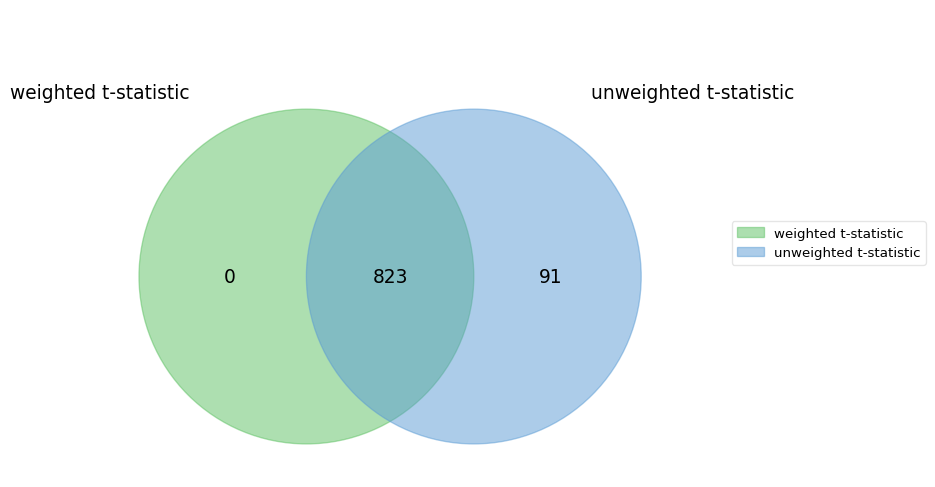

In [227]:
sets_comparison = {
    'weighted t-statistic': weighted_signif.index,
    'unweighted t-statistic': sig(voom_de_gene_sets)
}
venn2(sets_comparison);

In [228]:
voom_de_gene_sets.loc[
    sets_comparison['unweighted t-statistic'] - set(weighted_signif.index)
]

NGenes Direction  \
Post-transcriptional silencing by small RNAs           7.0        Up   
Protein repair                                         6.0        Up   
G beta:gamma signalling through PLC beta              19.0        Up   
Cargo recognition for clathrin-mediated endocyt...   104.0        Up   
Signaling by FGFR4 in disease                         11.0        Up   
...                                                    ...       ...   
HSF1 activation                                       29.0        Up   
RNA Polymerase II Transcription Initiation And ...    47.0        Up   
Glycerophospholipid biosynthesis                     121.0        Up   
Integration of provirus                                9.0        Up   
RHO GTPases activate PAKs                             21.0        Up   

                                                      PValue       FDR  \
Post-transcriptional silencing by small RNAs        0.016251  0.032426   
Protein repair                                      0.012338  0.025455   
G beta:gamma signalling through PLC beta            0.021153  0.040630   
Cargo recognition for clathrin-mediated endocyt...  0.017360  0.034237   
Signaling by FGFR4 in disease                       0.016501  0.032732   
...                                                      ...       ...   
HSF1 activation                                     0.014195  0.028901   
RNA Polymerase II Transcription Initiation And ...  0.015059  0.030297   
Glycerophospholipid biosynthesis                    0.020636  0.039864   
Integration of provirus                             0.018866  0.036694   
RHO GTPases activate PAKs                           0.022159  0.042340   

                                                     AveExpr  weighted_fdr  
Post-transcriptional silencing by small RNAs        0.078102      0.057120  
Protein repair                                     -0.008412           NaN  
G beta:gamma signalling through PLC beta            0.003035      0.069114  
Cargo recognition for clathrin-mediated endocyt...  0.001548      0.059674  
Signaling by FGFR4 in disease                       0.019100      0.057361  
...                                                      ...           ...  
HSF1 activation                                     0.008610      0.051958  
RNA Polymerase II Transcription Initiation And ...  0.001367      0.053817  
Glycerophospholipid biosynthesis                    0.000254      0.068043  
Integration of provirus                             0.019839      0.063068  
RHO GTPases activate PAKs                           0.028169      0.071531  

[91 rows x 6 columns]

In [229]:
%%R -o x -i voom_de_gene_sets
samples = by_condition_and_tb_subset_no_outliers == 'Cryptococcal' | by_condition_and_tb_subset_no_outliers == 'Definite tuberculosis'


voom_de_gene_sets$AveExpr = average_pathways_expression(
    tmm_normalized_tb_subsets, collection=reactome_new_symbol, id_type='symbol',
    pathways_subset=rownames(voom_de_gene_sets),
    #patients_subset=samples
)

x = add_p_value_for_filtered_subset(voom_de_gene_sets, fdr_threshold=0.05, expression_col='AveExpr', pvalue_col='PValue')
#, step=0.005, show_plot=T, use_deseq2_method=F)

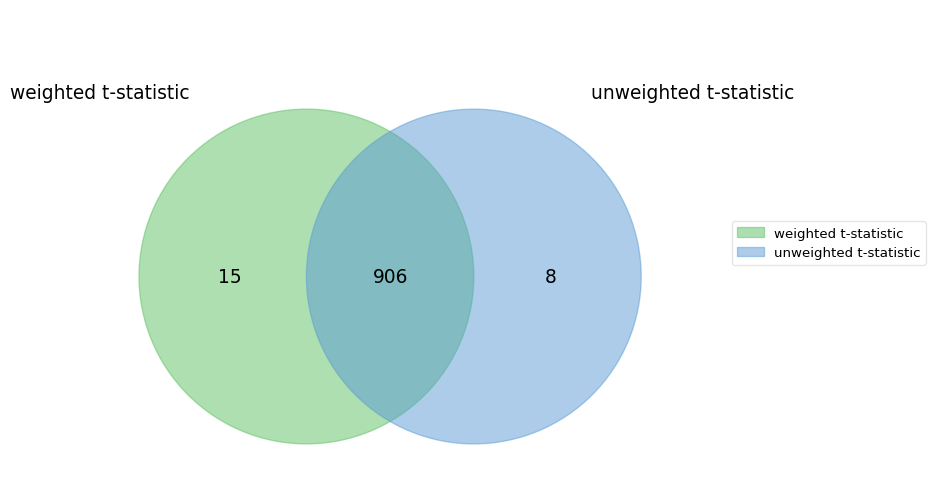

In [230]:
sets_comparison = {
    'weighted t-statistic': x[x['adj.P.Val'] < 0.05].index,
    'unweighted t-statistic': sig(voom_de_gene_sets)
}
venn2(sets_comparison);

In [231]:
x.loc[
    set(x[x['adj.P.Val'] < 0.05].index) - sig(voom_de_gene_sets)
]

NGenes Direction  \
Presynaptic function of Kainate receptors             20.0        Up   
Constitutive Signaling by NOTCH1 HD Domain Mutants    15.0        Up   
Activated NTRK3 signals through RAS                    8.0        Up   
Signaling by NOTCH1 HD Domain Mutants in Cancer       15.0        Up   
NRAGE signals death through JNK                       59.0        Up   
...                                                    ...       ...   
Formation of ATP by chemiosmotic coupling             18.0        Up   
Collagen formation                                    90.0      Down   
PCNA-Dependent Long Patch Base Excision Repair        21.0        Up   
Cross-presentation of particulate exogenous ant...     8.0        Up   
Negative regulation of FGFR4 signaling                30.0        Up   

                                                      PValue       FDR  \
Presynaptic function of Kainate receptors           0.028051  0.051772   
Constitutive Signaling by NOTCH1 HD Domain Mutants  0.027859  0.051531   
Activated NTRK3 signals through RAS                 0.029904  0.054659   
Signaling by NOTCH1 HD Domain Mutants in Cancer     0.027859  0.051531   
NRAGE signals death through JNK                     0.029033  0.053237   
...                                                      ...       ...   
Formation of ATP by chemiosmotic coupling           0.029547  0.054064   
Collagen formation                                  0.027981  0.051700   
PCNA-Dependent Long Patch Base Excision Repair      0.028098  0.051802   
Cross-presentation of particulate exogenous ant...  0.027314  0.050633   
Negative regulation of FGFR4 signaling              0.030298  0.055318   

                                                     AveExpr  weighted_fdr  \
Presynaptic function of Kainate receptors           0.003007      0.084577   
Constitutive Signaling by NOTCH1 HD Domain Mutants  0.016520      0.084369   
Activated NTRK3 signals through RAS                 0.021219      0.088611   
Signaling by NOTCH1 HD Domain Mutants in Cancer     0.016520      0.084369   
NRAGE signals death through JNK                     0.003129      0.086590   
...                                                      ...           ...   
Formation of ATP by chemiosmotic coupling           0.030106      0.087743   
Collagen formation                                  0.000293      0.084553   
PCNA-Dependent Long Patch Base Excision Repair     -0.000642           NaN   
Cross-presentation of particulate exogenous ant...  0.054008      0.083083   
Negative regulation of FGFR4 signaling              0.004404      0.089583   

                                                    adj.P.Val  
Presynaptic function of Kainate receptors            0.046720  
Constitutive Signaling by NOTCH1 HD Domain Mutants   0.046504  
Activated NTRK3 signals through RAS                  0.049375  
Signaling by NOTCH1 HD Domain Mutants in Cancer      0.046504  
NRAGE signals death through JNK                      0.048092  
...                                                       ...  
Formation of ATP by chemiosmotic coupling            0.048838  
Collagen formation                                   0.046656  
PCNA-Dependent Long Patch Base Excision Repair       0.046747  
Cross-presentation of particulate exogenous ant...   0.045694  
Negative regulation of FGFR4 signaling               0.049970  

[15 rows x 7 columns]

### Comparing overlap of different gene set collections

In [232]:
%%R -o sets_reactome_symbols -i voom_de -o sets_reactome_entrez -o sets_kegg_entrez
sets_reactome_symbols = camera_with_statistic(voom_de, 't', reactome_new_symbol, convert_to='symbol')
sets_reactome_entrez = camera_with_statistic(voom_de, 't', c2.cp.reactome, convert_to='entrez')
sets_kegg_entrez = camera_with_statistic(voom_de, 't', c2.cp.kegg, convert_to='entrez')

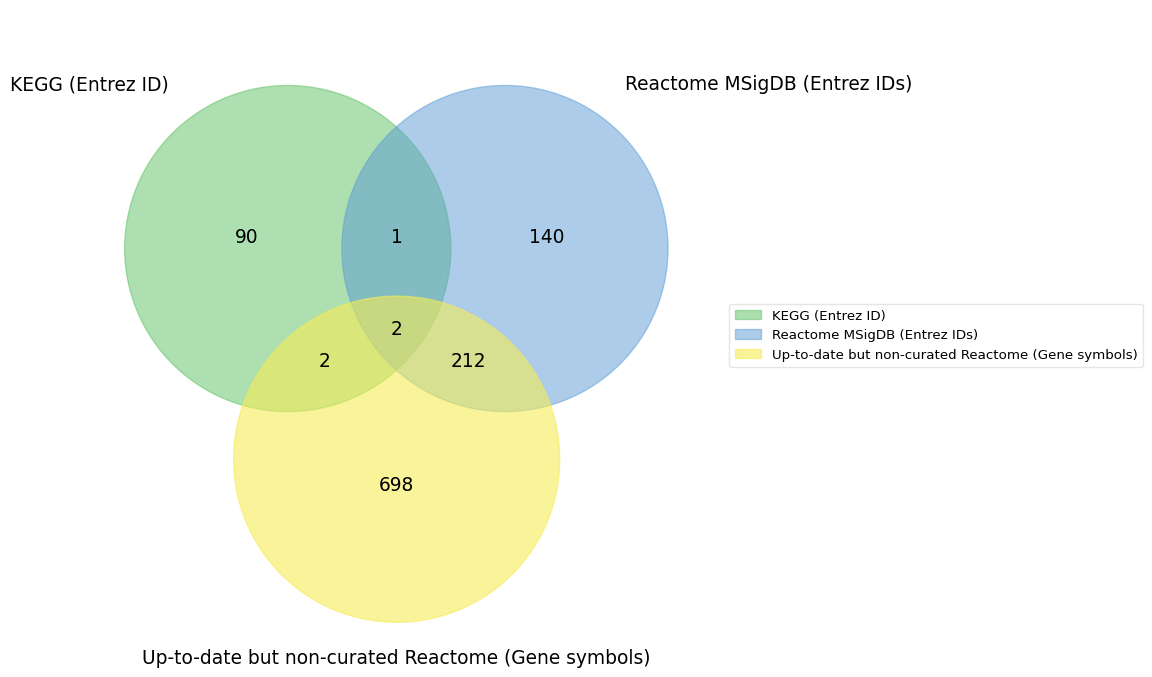

In [233]:
sig = lambda x: set(x[x.FDR < 0.05].index.str.lower())
sets_comparison = {
    'KEGG (Entrez ID)': sig(sets_kegg_entrez),
    'Reactome MSigDB (Entrez IDs)': sig(sets_reactome_entrez),
    'Up-to-date but non-curated Reactome (Gene symbols)': sig(sets_reactome_symbols)
}
venn3(sets_comparison);